In [ ]:
import yfinance as yf
import mplfinance as mpf
from binance.client import Client
import os
import ta
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import polars as pl
import datetime

data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data

BINANCE connection setup

In [1037]:
# GENERJET API KEY and SECRET
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

client = Client(api_key, api_secret)

FETCH DATA

In [1035]:
# ====== get data function ======
def fetchCryptoData(symbol, timePeriod ,lookback, ago='days ago UTC'):
    frame = pd.DataFrame(client.get_historical_klines(symbol, timePeriod, lookback + ago ))
    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame.set_index('Time', inplace=True)
    frame.index = pd.to_datetime(frame.index, unit='ms')
    frame = frame.astype(float)
    return frame


In [1036]:
symbol = 'ETHUSDT'
timePeriod = '30m'
lookback = '7'
df = fetchCryptoData(symbol, timePeriod, lookback )
df

NameError: name 'client' is not defined

SLOPE, INTERCEPTS and difference STEPS

In [858]:
# 2 argument l avna
def direction_and_steps(datapoints):
    if datapoints.index[0] > datapoints.index[1]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    ascending = False

# ========================
    if b.index < a.index:
        oldIndex = b.index
        newIndex = a.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = False
            # print("descending")
        else:
            max = a_value
            min = b_value
            ascending = True
            # print('ascending')
    elif b.index > a.index:
        oldIndex = a.index
        newIndex = b.index
        if b_value > a_value:
            max = b_value
            min = a_value
            ascending = True
            # print('ascending')
        else:
            max = a_value
            min = b_value
            ascending = False
            # print('descending')

    top_diff = max - min
    # print('difference = ', top_diff)
    filtered = df[(df.index <= startIndex) & (df.index >= endIndex)]
    numrange = len(filtered)
    # print('range =', numrange)
    diff_step = top_diff/numrange
    return diff_step, ascending
# === test ===
resistance_points = resistances.sort_values(ascending=False).tail(2)

diff_step, lineAscending = direction_and_steps(resistance_points)
# print('diff = ', diff_step)
lineAscending

RETURN min & max from 2 POINTS

In [700]:
def min_max(datapoints):
    a = datapoints.head(1)
    b = datapoints.tail(1)
    a_value = a[0]
    b_value = b[0]
    if b_value > a_value:
        max = b_value
        min = a_value
        # print("max= ", max, "min= ", min)
    else:
        max = a_value
        min = b_value
        # print("max= ", max, "min= ", min)
    return min, max

In [701]:
min_max(resistance_points)

max=  241.97799682617188 min=  237.90899658203125


(237.90899658203125, 241.97799682617188)

EXTREMUM hoorondiin data range easify

In [702]:
def start_end_ragne(datapoints):
    if datapoints.index[1] > datapoints.index[0]:
        startIndex = datapoints.index[0]
        endIndex = datapoints.index[1]
    else:
        startIndex = datapoints.index[1]
        endIndex = datapoints.index[0]
    return startIndex, endIndex

start, end = start_end_ragne(resistance_points)
# print("started= ", start)
# print('ended =', end)

started=  2015-04-22 00:00:00
ended = 2015-05-24 00:00:00


LEVELS

In [884]:
resistances

Date
2015-04-22    237.908997
2015-05-03    243.240005
2015-05-09    247.804001
2015-05-24    241.977997
2015-06-17    256.852997
2015-06-30    267.867004
Name: High, dtype: float64

In [885]:
resistance_points

Date
2015-05-24    241.977997
2015-04-22    237.908997
Name: High, dtype: float64

RESISTANCE until NOW

In [ ]:
def resistance(df):
    # print("Calculating resistance")
    resistances = df[df.High == df.High.rolling(10, center=True).max()].High
    resistance_points = resistances.sort_values(ascending=True).tail(2)

    # resistance coefficients
    diff_step, lineAscending = direction_and_steps(resistance_points)
    start, end = start_end_ragne(resistance_points)
    # today = df[(df.index > resistance_points.index[0])]
    today = df[(df.index > start)]

    x_values = []
    y_values = []

    min, max = min_max(resistance_points)
    y = resistance_points[0]
    # today['resistance'] = np.nan

    if lineAscending == True:
        y = min
        for i in today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y
    elif lineAscending == False:
        y = max
        for i in today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            # today.loc[today.index==i, 'resistance'] = y
            df.loc[df.index==i, 'resistance'] = y

    # print("Resistance ascending", lineAscending)
    # print("Diff points", diff_step)
    # # y_values
# ==== run test ====
# resistance(df)

SUPPORT

In [853]:
def support(df):
    supports = df[df.Low == df.Low.rolling(10, center=True).min()].Low
    support_points = supports.sort_values(ascending=True).head(2)
    
    # start_point
    start, end = start_end_ragne(support_points)
    support_today = df[(df.index > start)]
    # support coefficients
    diff_step, lineAscending = direction_and_steps(support_points)

    numrange = len(support_today)
    x_values = []
    y_values = []

    min, max = min_max(support_points)
    y = support_points[0]

    if lineAscending == True:
        y = min
        for i in support_today.index:
            y = y + diff_step
            y_values.append(y)
            x_values.append(i)
            df.loc[df.index==i, 'support'] = y
    elif lineAscending == False:
        y = max
        for i in support_today.index:
            y = y - diff_step
            y_values.append(y)
            x_values.append(i)
            df.loc[df.index==i, 'support'] = y

# run test
# support(df)

PLOT and SAVE

In [1010]:
# ====== PLOTTING and SAVING =========
# MATPLOTLIB
# clean_levels = levels[abs(levels.diff() > 0)]
def plot_df(df):
# ==== SUBPLOTS =====
    fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(12,9))
    axes[0].plot(df['High'], label="High")
    axes[0].plot(df['Low'], label='Low')
    axes[0].set_title("ETHUSDT Price movement")
    axes[0].plot(df['resistance'], 'r--', label="resistance")
    axes[0].plot(df['support'], 'g--', label="support")
    axes[0].plot(df.index, df['Buy'], 'ro')
    axes[0].plot(df.index, df['Sell'], 'go')
    axes[1].plot(df["%D"], 'r', label="%D")
    axes[1].plot(df["%K"], 'b', label="%K")
    axes[1].set_title("STOCHASTIC OSCILLATOR")
    axes[2].plot(df["rsi"], 'r', label="RSI")
    axes[2].set_title("RSI")
    axes[3].plot(df["macd"], 'r', label="MACD")
    axes[3].set_title("MACD")
    fig.tight_layout()
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    startDate = df.index[0].strftime("%Y-%m-%d")
    endDate = df.index[-1].strftime("%Y-%m-%d")
    save_name = startDate + '_to_' + endDate
    save_name
    plt.savefig('charts/1h_test_' +save_name+'_signals.jpg')

MACD & RSI & STOCHASTIC OSCILLATOR

In [990]:
data['macd'] = np.nan
data['rsi'] = np.nan
data['%D'] = np.nan
data['%K'] = np.nan
df = data[0:100]

In [979]:
def applytechnicals(df):
    # window for 14 days and smooth window for 3days
    df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3)
    df['%D'] = df['%K'].rolling(3).mean()
    df['rsi'] = ta.momentum.rsi(df.Close, window=14)
    df['macd'] = ta.trend.macd_diff(df.Close)
    df.dropna(inplace=True)
    return df

BUY SIGNALS

In [1029]:
def decide():
    # ===== working signals without SUPPORT and RESISTANCES =============== 1
    # df['Buy'] = np.where( (df['%K'].between(2,25)) & (df['%D'].between(2,25)) & (df['%K'] > df['%D'] ) & (df.rsi < 55) , df["Close"], np.nan)
    # df['Sell'] = np.where( (df['%K'].between(70,100)) & (df['%D'].between(70,100)) & (df['%K'] < df['%D'] ) & (df.rsi > 70 ) , df["Close"], np.nan)
    # ===== working signals without SUPPORT and RESISTANCES ===============

    # ===== working signals without SUPPORT and RESISTANCES =============== 2
    # df['Buy'] = np.where( (df['%K'].between(2,40)) & (df['%D'].between(2,40)) & (df['%K'] > df['%D'] ) & (df.rsi < 50) , df["Close"], np.nan)
    # df['Sell'] = np.where( (df['%K'].between(65,100)) & (df['%D'].between(65,100)) & (df['%K'] < df['%D'] ) & (df.rsi > 60 ) , df["Close"], np.nan)
    # ===== working signals without SUPPORT and RESISTANCES ===============

    # ===== working signals with SUPPORT and RESISTANCES =============== SUPER
    resistance_zone = df['resistance'] - 10
    support_zone = df['support'] + 10
    df['Buy'] = np.where( ( df['Low'] < support_zone ) & ( df['support'] < df['resistance'] ) & (df['%K'].between(0,20)) & (df['%D'].between(0,20)) & (df['%K'] > df['%D'] ) & (df.rsi < 40) , df["Close"], np.nan)
    df['Sell'] = np.where( ( df['High'] > resistance_zone) & ( df['support'] < df['resistance'] ) & (df['%K'].between(55,100)) & (df['%D'].between(55,100)) & (df['%K'] < df['%D'] ) & (df.rsi > 55 ) , df["Close"], np.nan)
    # ===== working signals without SUPPORT and RESISTANCES ===============

In [ ]:
df

PLOTTING

In [ ]:
resistance(df)
support(df)
applytechnicals(df)

In [ ]:
decide()
plot_df(df)
# ===== PLOT =====
# clean_levels = levels[abs(levels.diff() > 0)]
# df.High.plot()
# df.Low.plot()

# plt.hlines(clean_levels, xmin=clean_levels.index, xmax=clean_levels.index[-1], colors='red')
# plt.scatter(resistances.index, resistances, color='b')
# plt.plot(df.index, df['resistance'], 'r--')
# plt.plot(df.index, df['support'], "g--")
# plt.scatter(df.index, df['Buy'], color="r")
# plt.scatter(df.index, df['Sell'], color="b")

TEST by ONE

Test with Iteration

/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

max=  457.0929870605469 min=  411.697998046875
Resistance ascending True
Diff points 1.464354484311996
max=  304.23199462890625 min=  289.2959899902344
Start=  0  end =  100
max=  309.3840026855469 min=  300.04400634765625
Resistance ascending False
Diff points 0.21227264404296875
max=  212.01499938964844 min=  171.50999450683594


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  100  end =  200
max=  267.86700439453125 min=  256.8529968261719
Resistance ascending True
Diff points 0.7867148263113839
max=  216.322998046875 min=  214.87399291992188


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  200  end =  300
max=  297.77398681640625 min=  273.5780029296875
Resistance ascending False
Diff points 0.29151787815323793
max=  211.07899475097656 min=  199.56700134277344


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  300  end =  400
max=  495.56201171875 min=  469.1029968261719
Resistance ascending False
Diff points 0.678436279296875
max=  312.2170104980469 min=  300.99700927734375


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  400  end =  500
max=  467.9649963378906 min=  448.0459899902344
Resistance ascending True
Diff points 0.30180312647964014
max=  406.1369934082031 min=  394.0350036621094


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  500  end =  600
max=  777.989990234375 min=  704.968017578125
Resistance ascending False
Diff points 4.563873291015625
max=  531.333984375 min=  437.3890075683594


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  600  end =  700
max=  756.2369995117188 min=  745.7730102539062
Resistance ascending True
Diff points 0.6155287798713235
max=  595.7860107421875 min=  568.6300048828125


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  700  end =  800
max=  1200.3900146484375 min=  1191.0999755859375
Resistance ascending True
Diff points 0.1821576286764706
max=  946.6909790039062 min=  755.7559814453125


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  800  end =  900
max=  2999.909912109375 min=  2763.7099609375
Resistance ascending True
Diff points 18.169227013221153
max=  957.655029296875 min=  903.7130126953125


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  900  end =  1000
max=  4975.0400390625 min=  4484.7001953125
Resistance ascending True
Diff points 28.843520220588236
max=  2332.989990234375 min=  1843.030029296875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1000  end =  1100
max=  20089.0 min=  18353.400390625
Resistance ascending True
Diff points 173.5599609375
max=  5397.8798828125 min=  5151.43994140625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1100  end =  1200
max=  17712.400390625 min=  12040.2998046875
Resistance ascending False
Diff points 246.61306895380434
max=  6526.8701171875 min=  6048.259765625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1200  end =  1300
max=  9964.5 min=  9745.3203125
Resistance ascending True
Diff points 19.925426136363637
max=  6136.419921875 min=  5826.41015625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1300  end =  1400
max=  8424.26953125 min=  7388.43017578125
Resistance ascending False
Diff points 23.541803533380683
max=  6197.52001953125 min=  5971.0498046875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1400  end =  1500
max=  6552.16015625 min=  6547.14013671875
Resistance ascending True
Diff points 0.7171456473214286
max=  3280.228759765625 min=  3191.303466796875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1500  end =  1600
max=  5642.04443359375 min=  5421.6513671875
Resistance ascending True
Diff points 14.69287109375
max=  3607.69775390625 min=  3391.023681640625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1600  end =  1700
max=  13796.4892578125 min=  13129.529296875
Resistance ascending False
Diff points 44.46399739583333
max=  9163.134765625 min=  7564.48876953125


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1700  end =  1800
max=  10898.76171875 min=  10021.744140625
Resistance ascending False
Diff points 17.196423100490197
max=  7446.98876953125 min=  6617.1669921875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1800  end =  1900
max=  10457.626953125 min=  9553.1259765625
Resistance ascending True
Diff points 60.30006510416667
max=  6914.99609375 min=  6540.04931640625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  1900  end =  2000
max=  10199.5654296875 min=  9996.7431640625
Resistance ascending True
Diff points 8.112890625
max=  6555.50439453125 min=  5903.234375


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2000  end =  2100
max=  12359.056640625 min=  12067.0810546875
Resistance ascending False
Diff points 18.24847412109375
max=  8977.015625 min=  8975.525390625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2100  end =  2200
max=  24209.66015625 min=  19845.974609375
Resistance ascending True
Diff points 218.18427734375
max=  11223.0126953125 min=  10416.689453125


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2200  end =  2300
max=  61683.86328125 min=  60267.1875
Resistance ascending False
Diff points 67.46075148809524
max=  30549.599609375 min=  28953.373046875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2300  end =  2400
max=  59519.35546875 min=  58973.30859375
Resistance ascending True
Diff points 68.255859375
max=  30681.49609375 min=  28893.62109375


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2400  end =  2500
max=  66930.390625 min=  52853.765625
Resistance ascending True
Diff points 319.92329545454544
max=  39787.609375 min=  37458.00390625


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2500  end =  2600
max=  68789.625 min=  51956.328125
Resistance ascending False
Diff points 350.6936848958333
max=  39796.5703125 min=  33184.05859375


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2600  end =  2700
max=  48086.8359375 min=  45077.578125
Resistance ascending True
Diff points 111.45399305555556
max=  34459.21875 min=  26350.490234375


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2700  end =  2800
max=  32249.86328125 min=  25135.58984375
Resistance ascending False
Diff points 92.39316152597402
max=  18729.65625 min=  17708.623046875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2800  end =  2900
max=  22673.8203125 min=  21446.88671875
Resistance ascending False
Diff points 22.72099247685185
max=  15682.6923828125 min=  15599.046875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  2900  end =  3000
max=  25134.1171875 min=  24167.2109375
Resistance ascending True
Diff points 64.46041666666666
max=  16408.474609375 min=  16398.13671875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  3000  end =  3100
max=  31005.607421875 min=  29995.837890625
Resistance ascending False
Diff points 77.67457932692308
max=  25434.8671875 min=  24797.16796875


/tmp/ipykernel_3191/651809566.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/651809566.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/657613115.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3191/65

Start=  3100  end =  3200


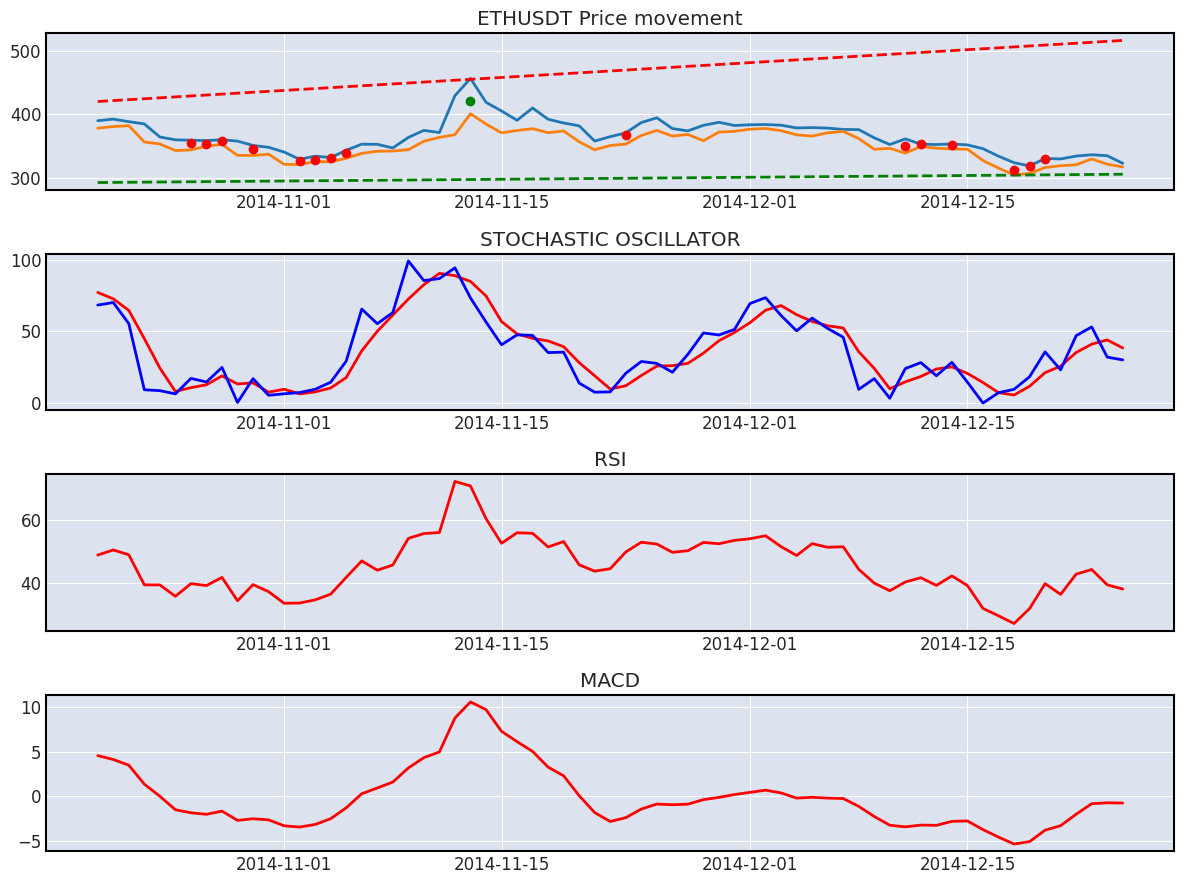

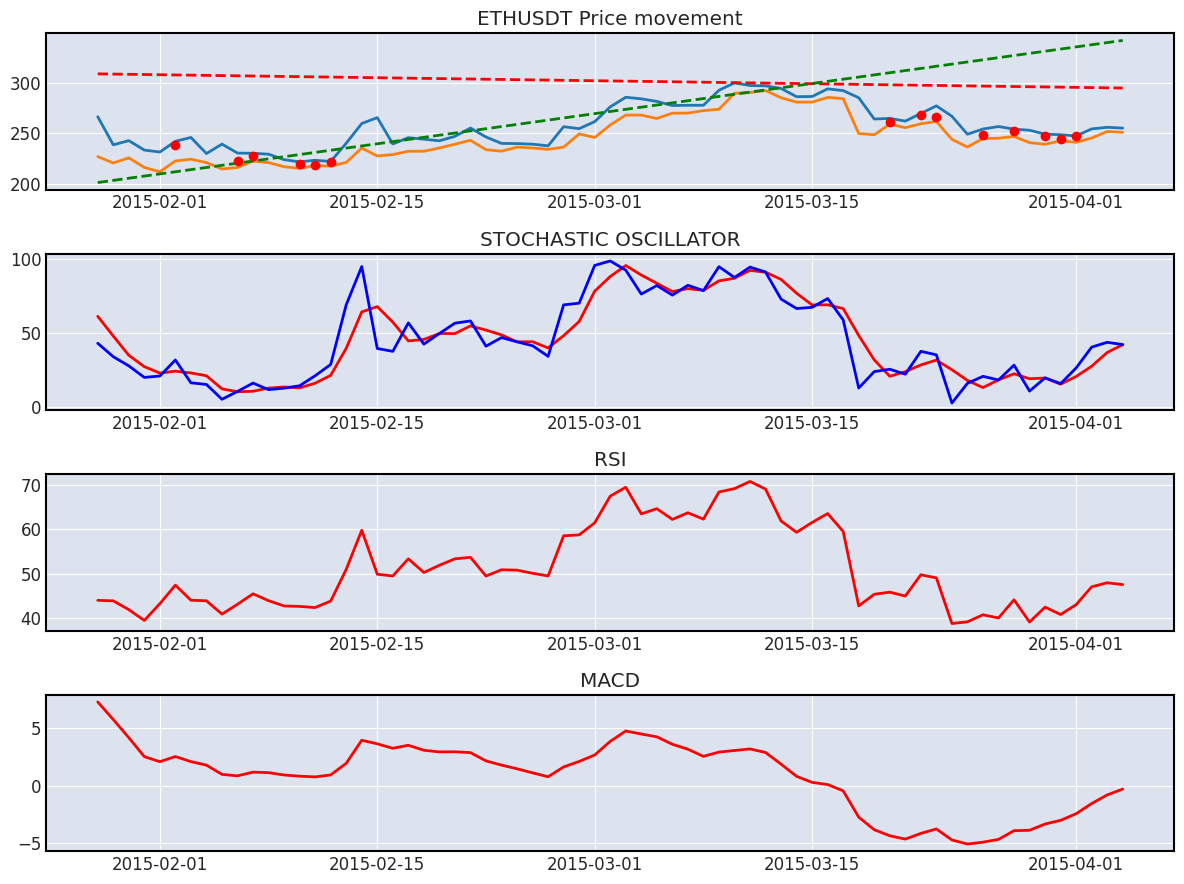

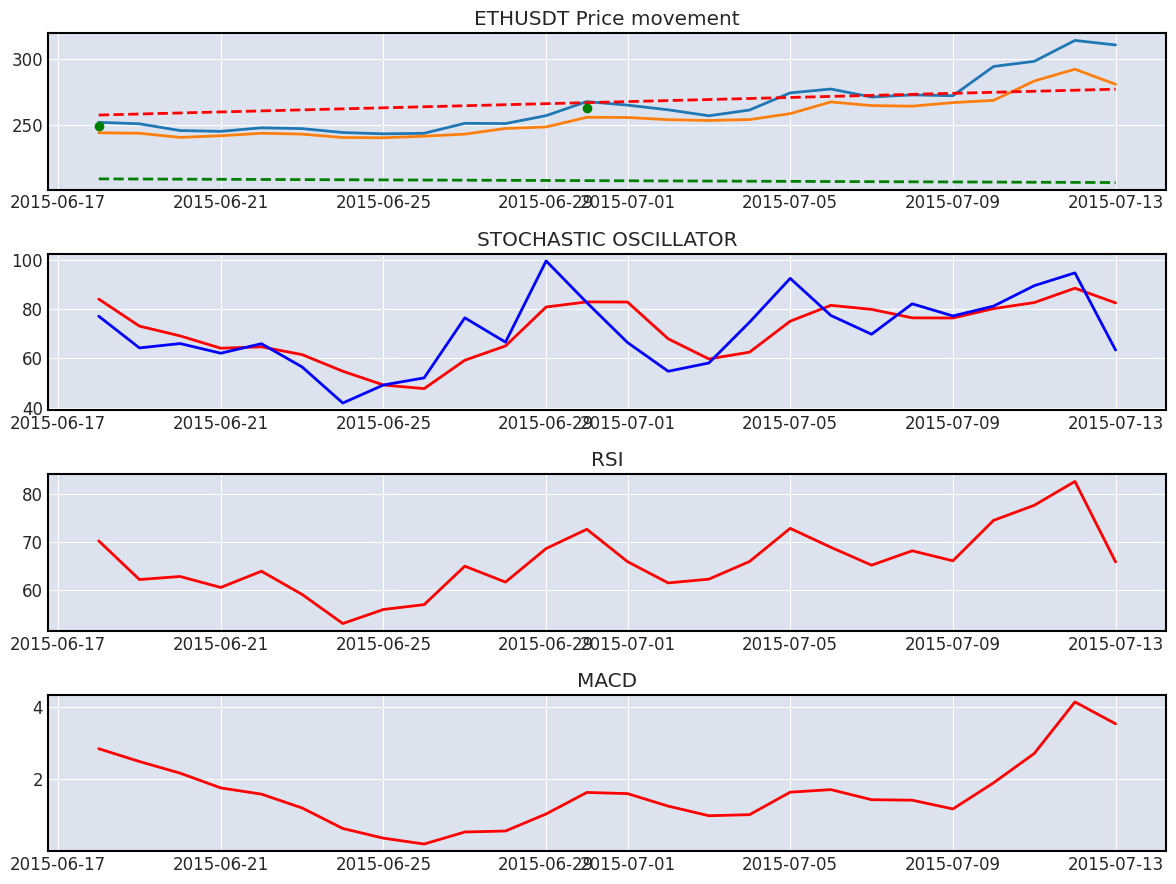

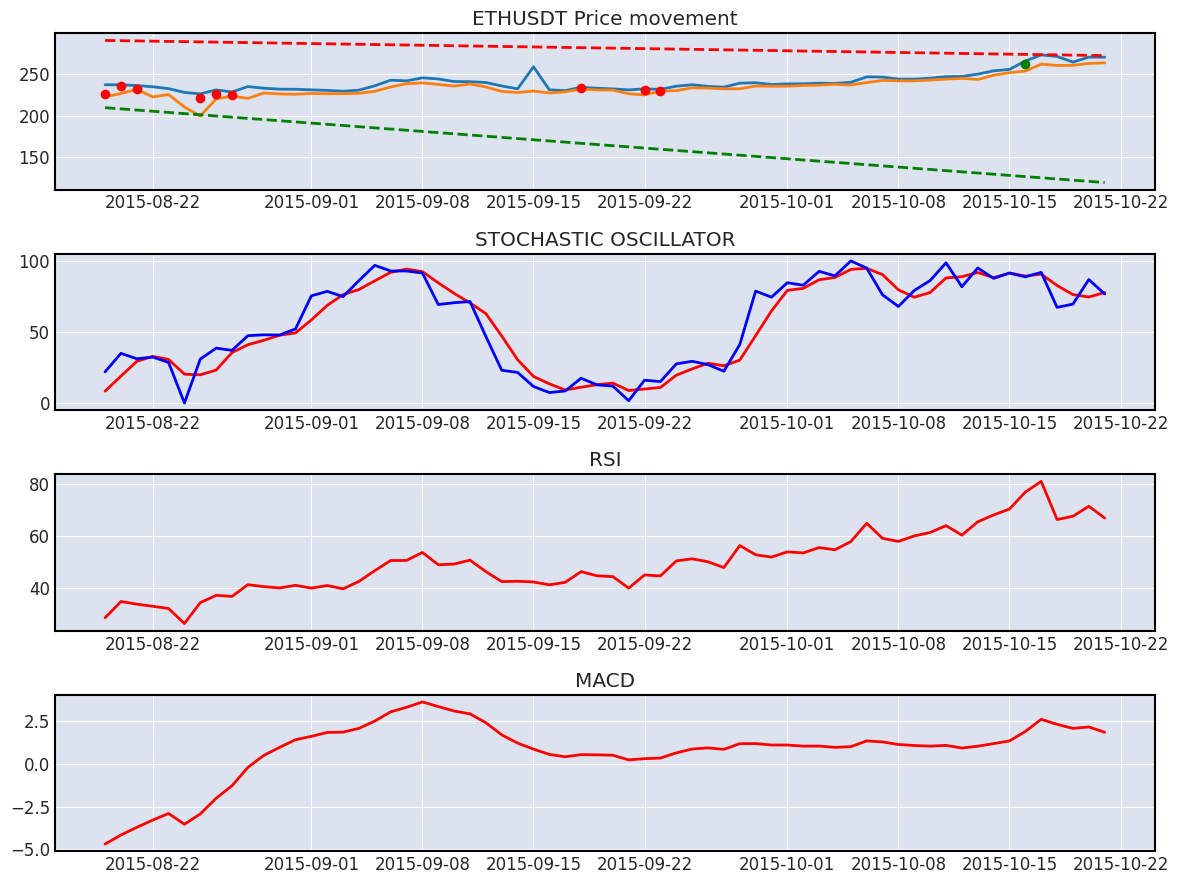

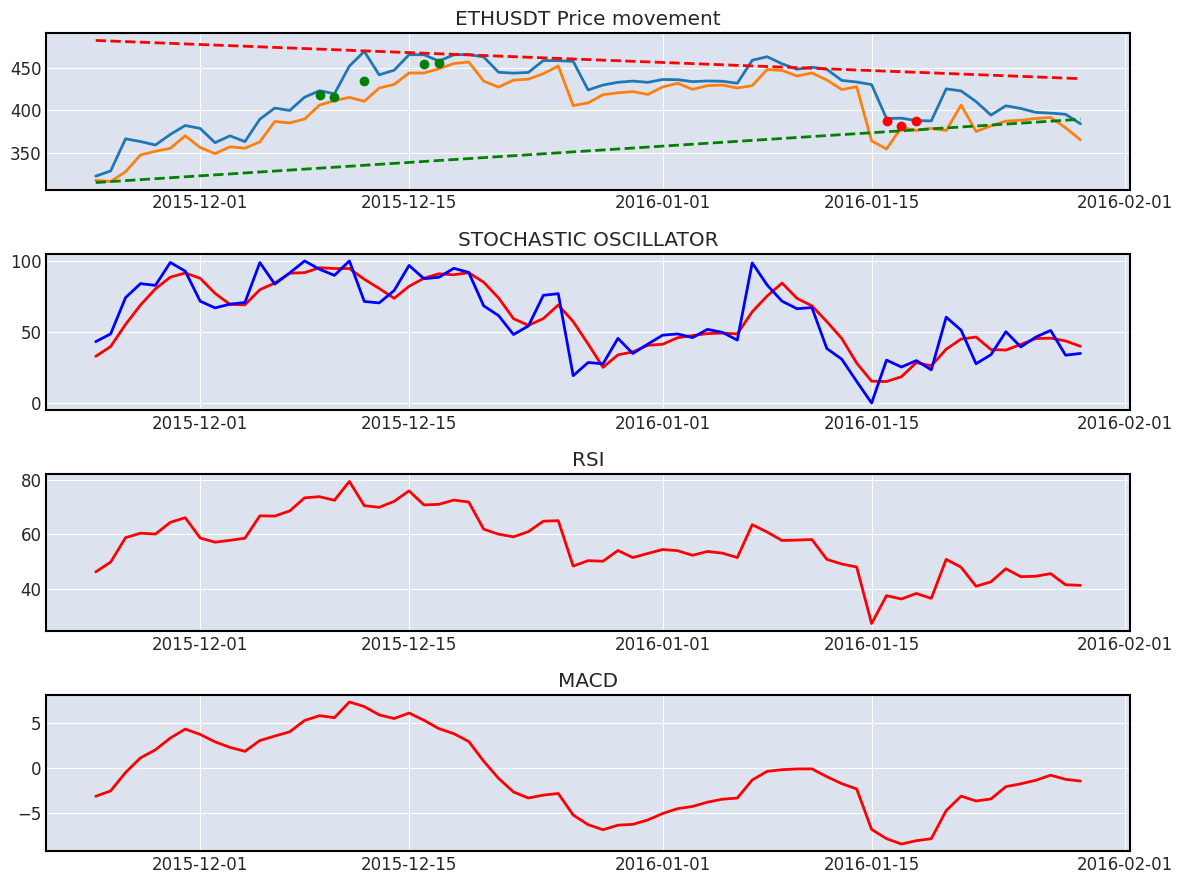

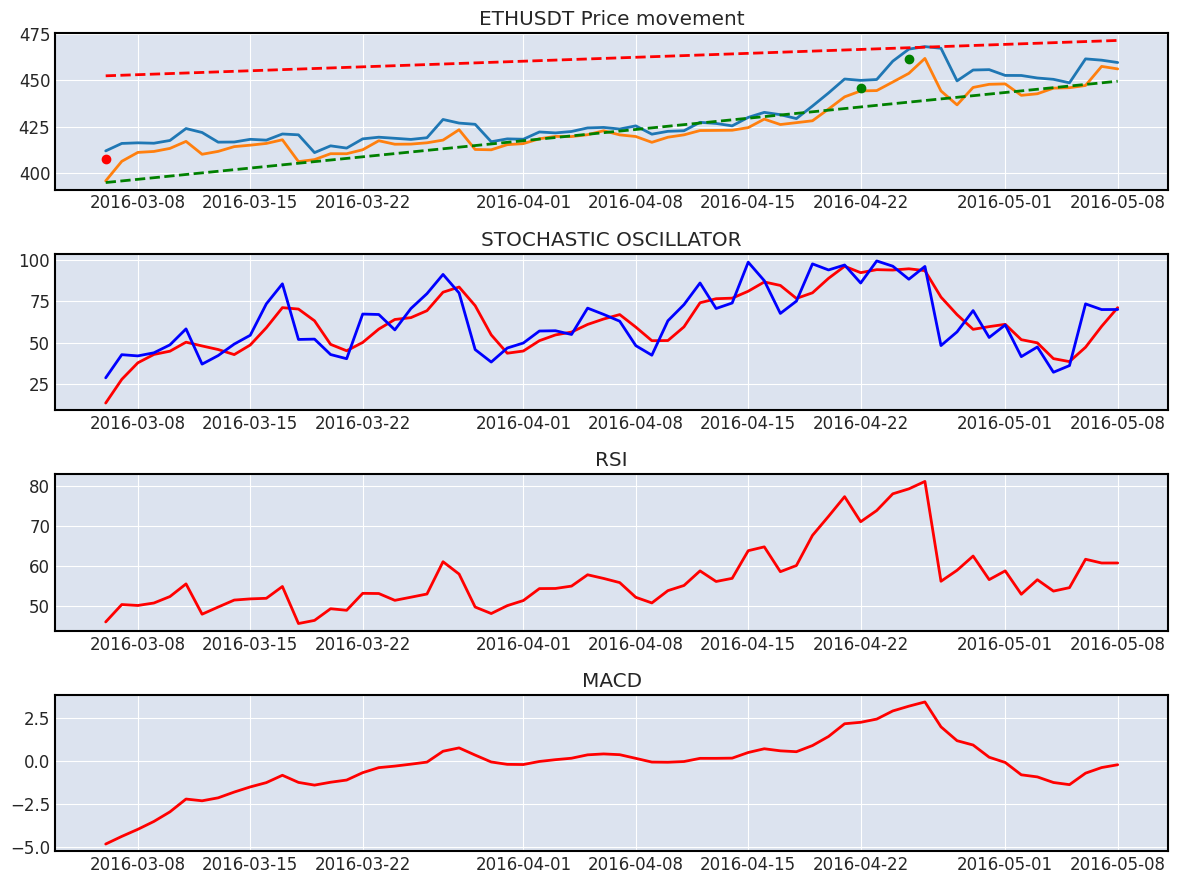

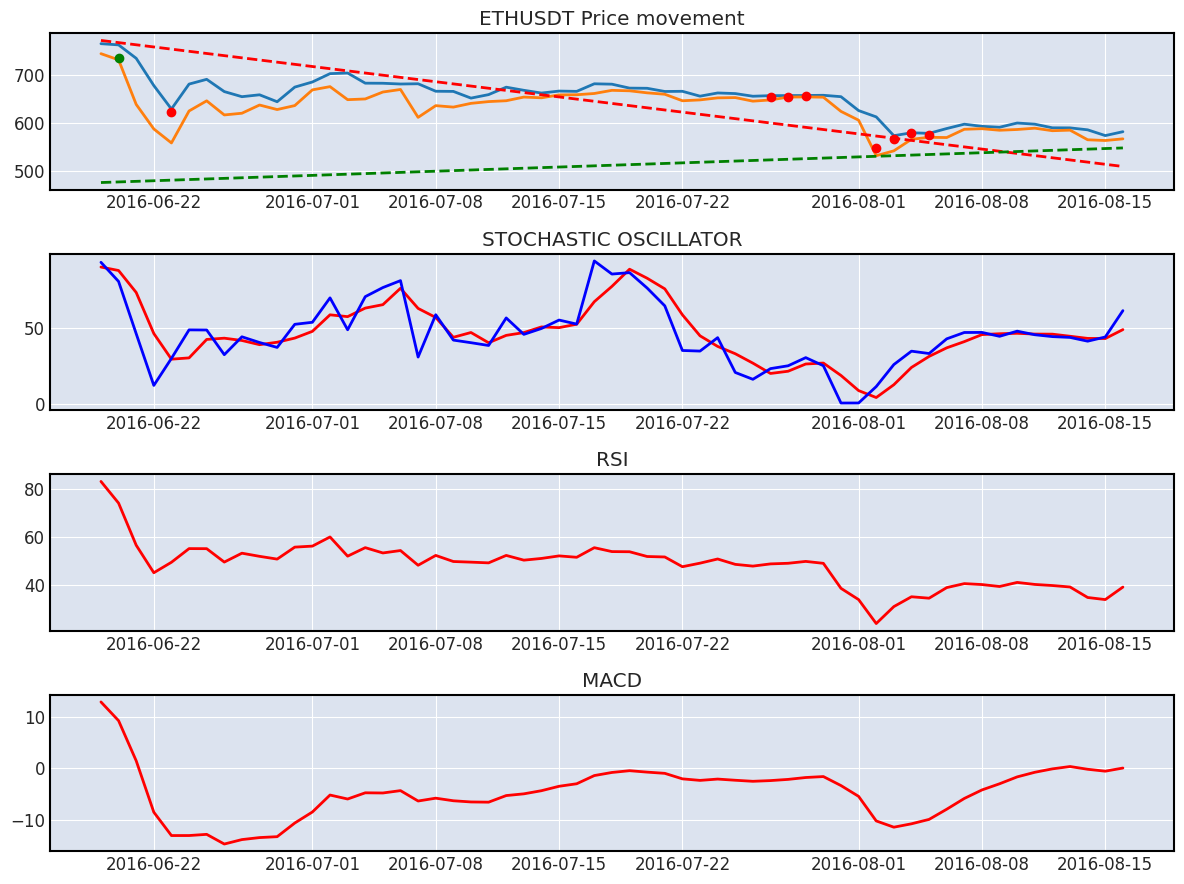

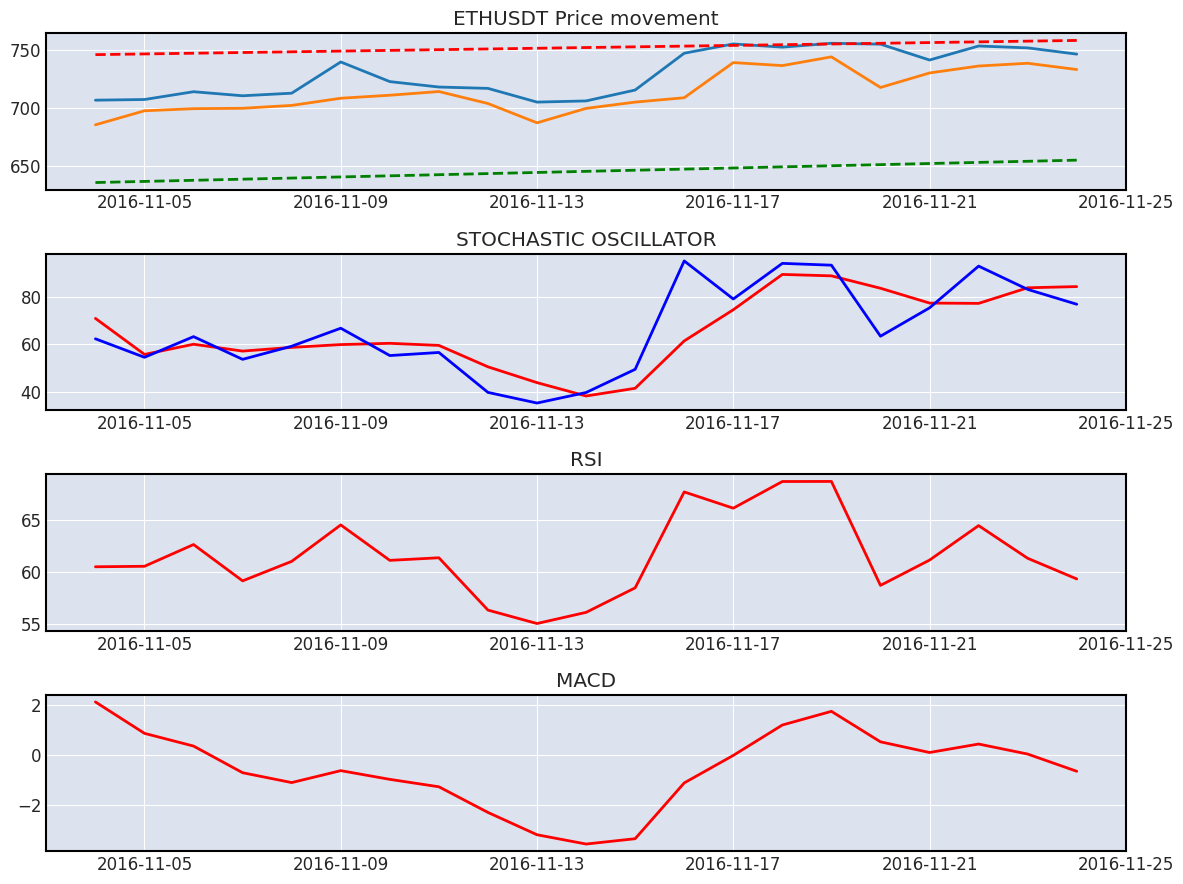

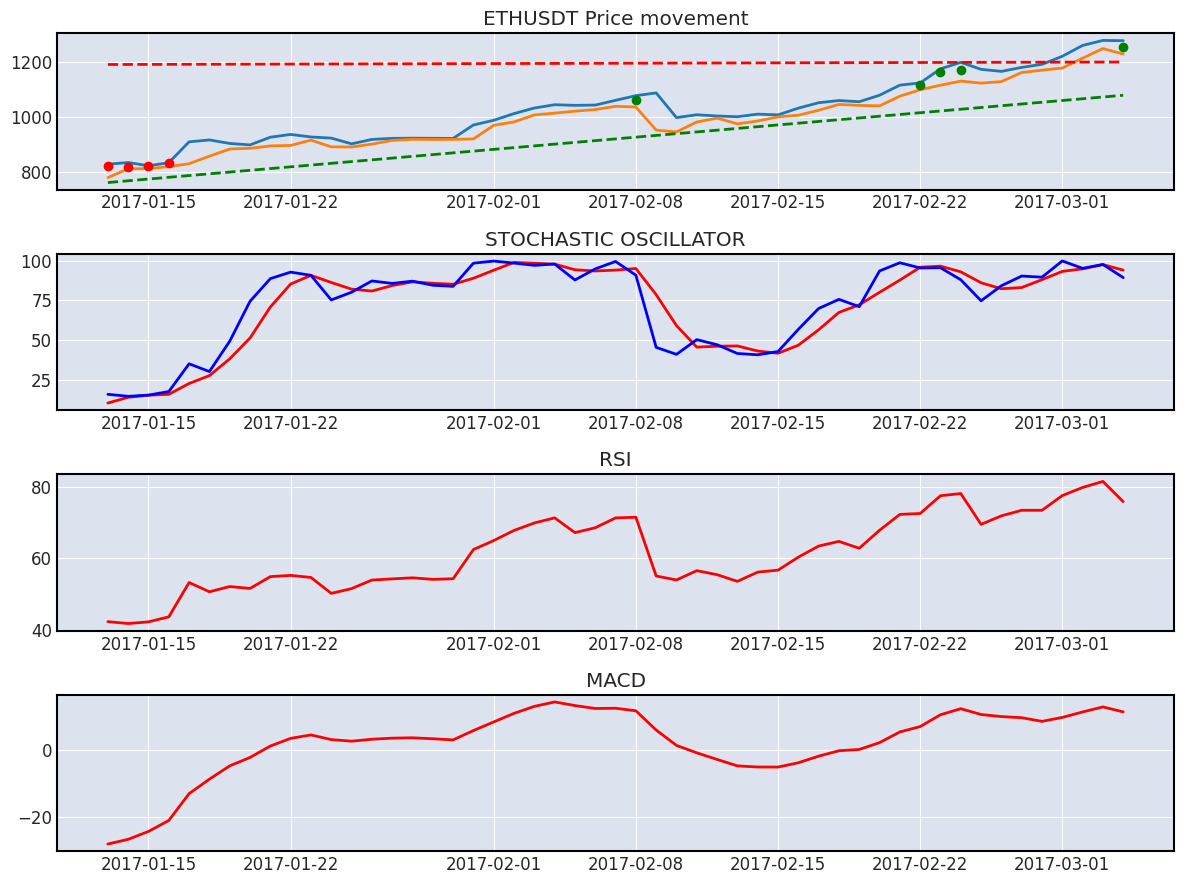

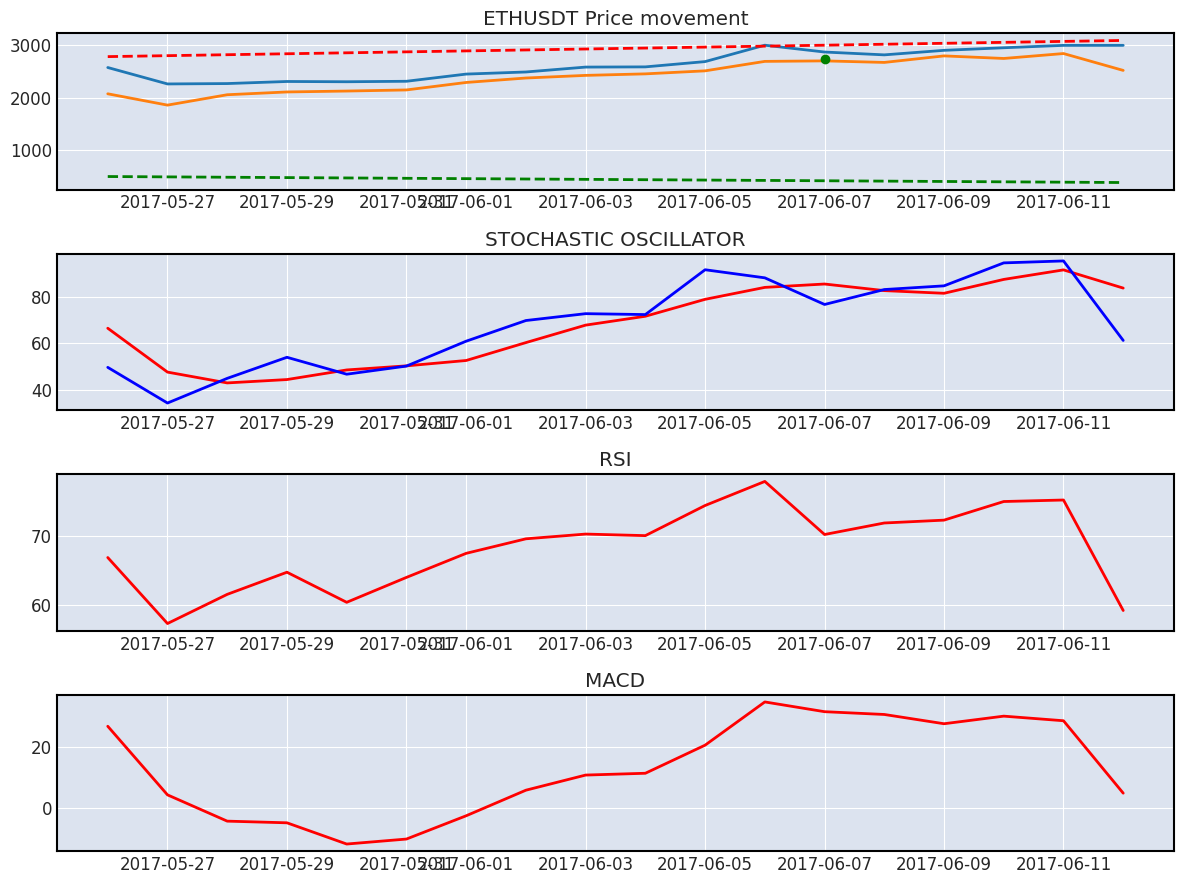

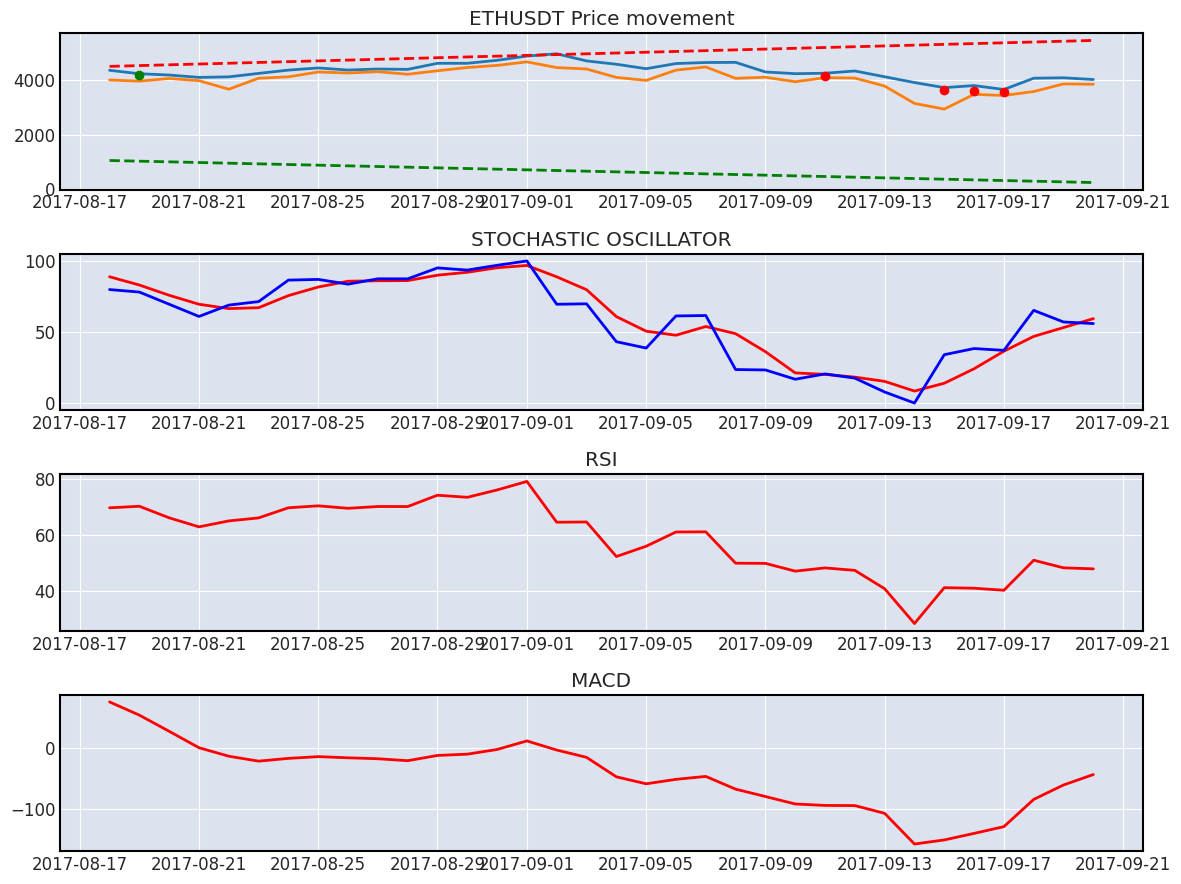

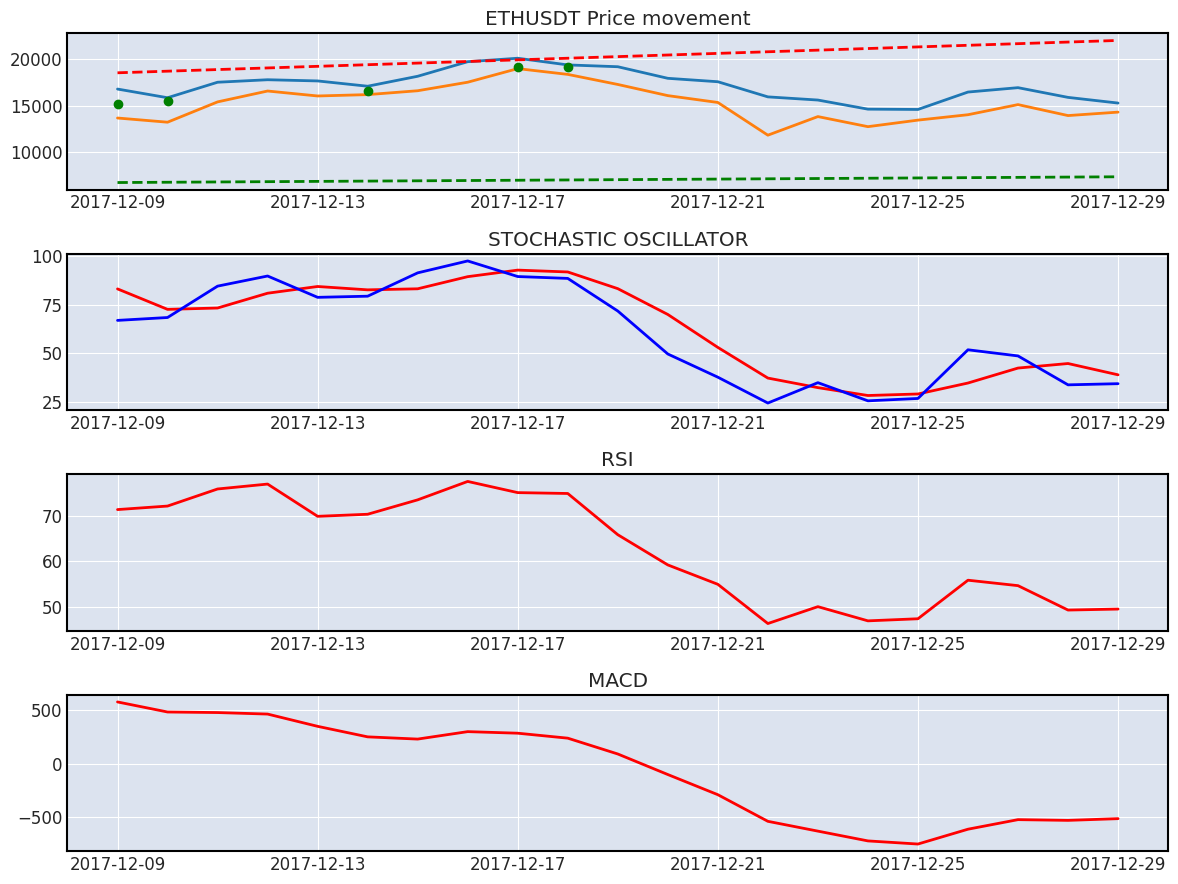

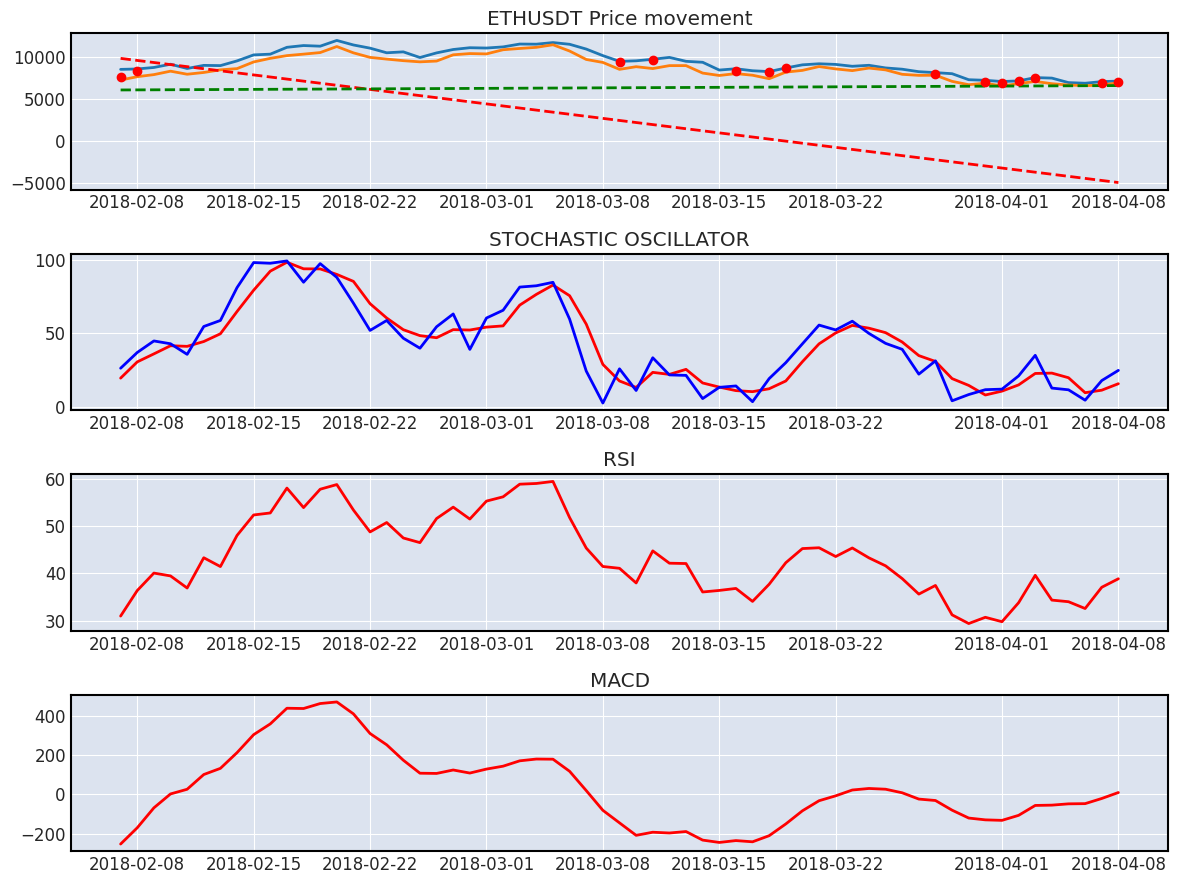

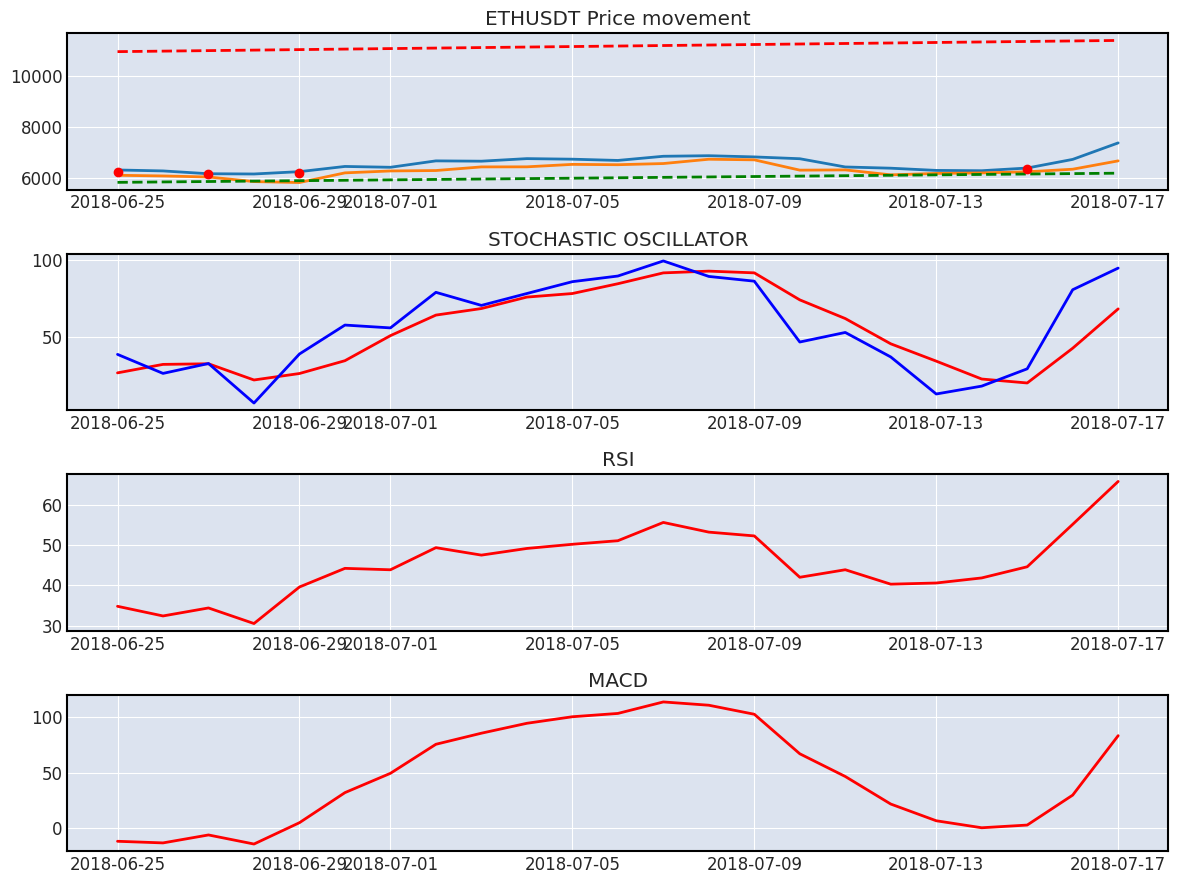

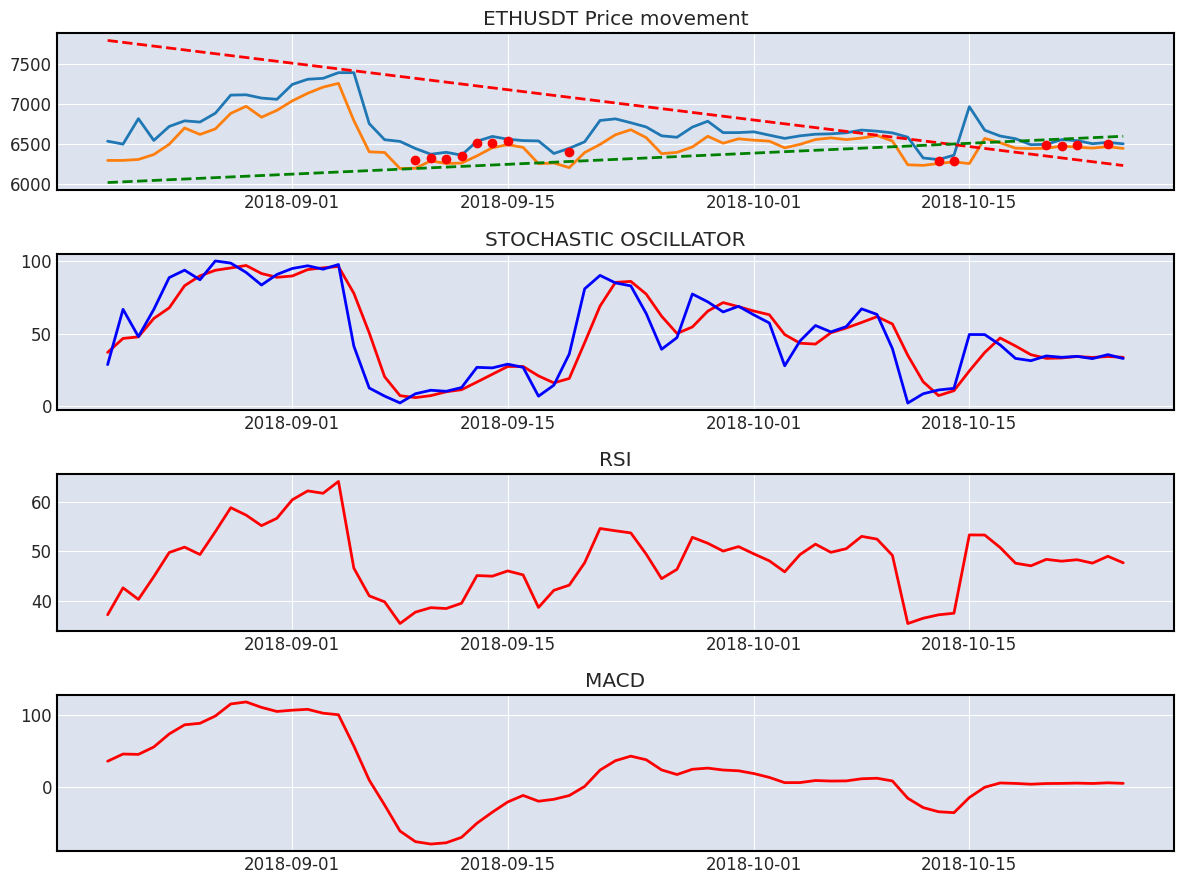

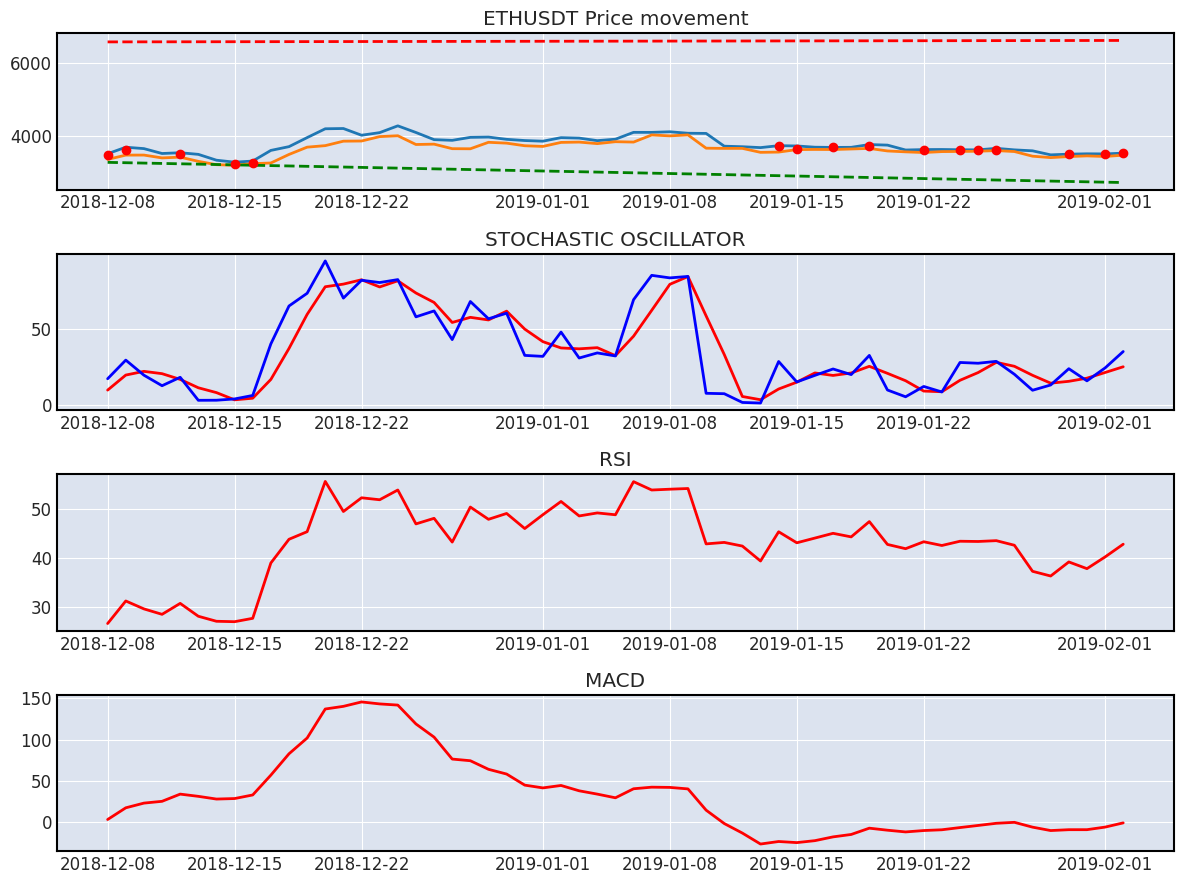

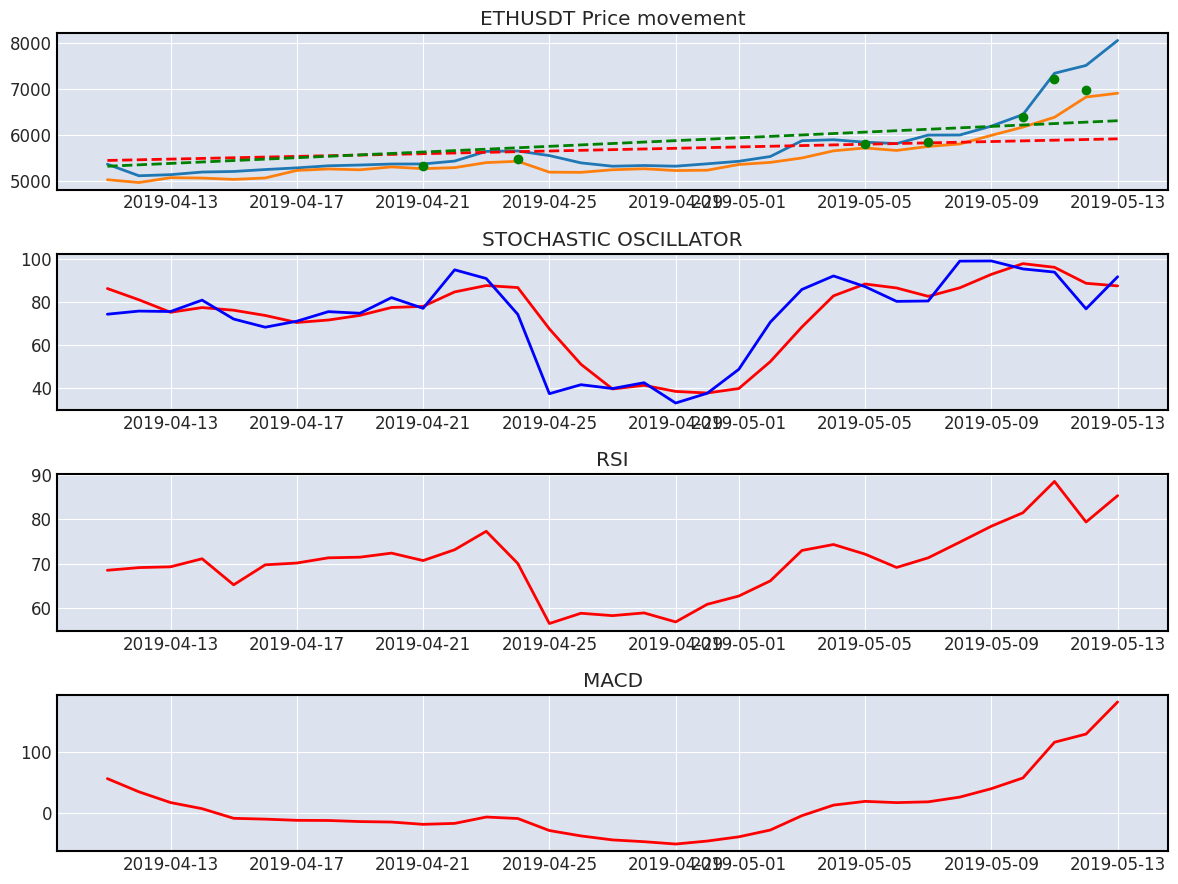

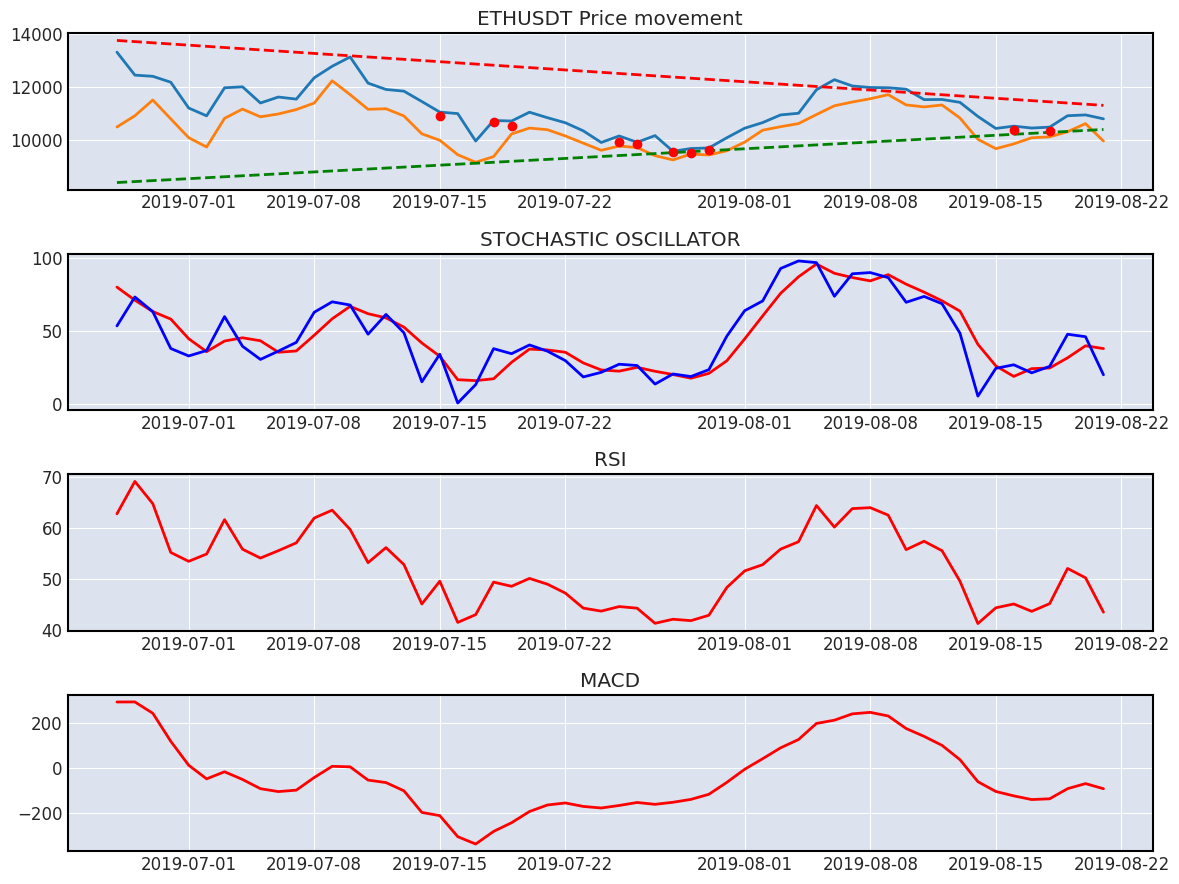

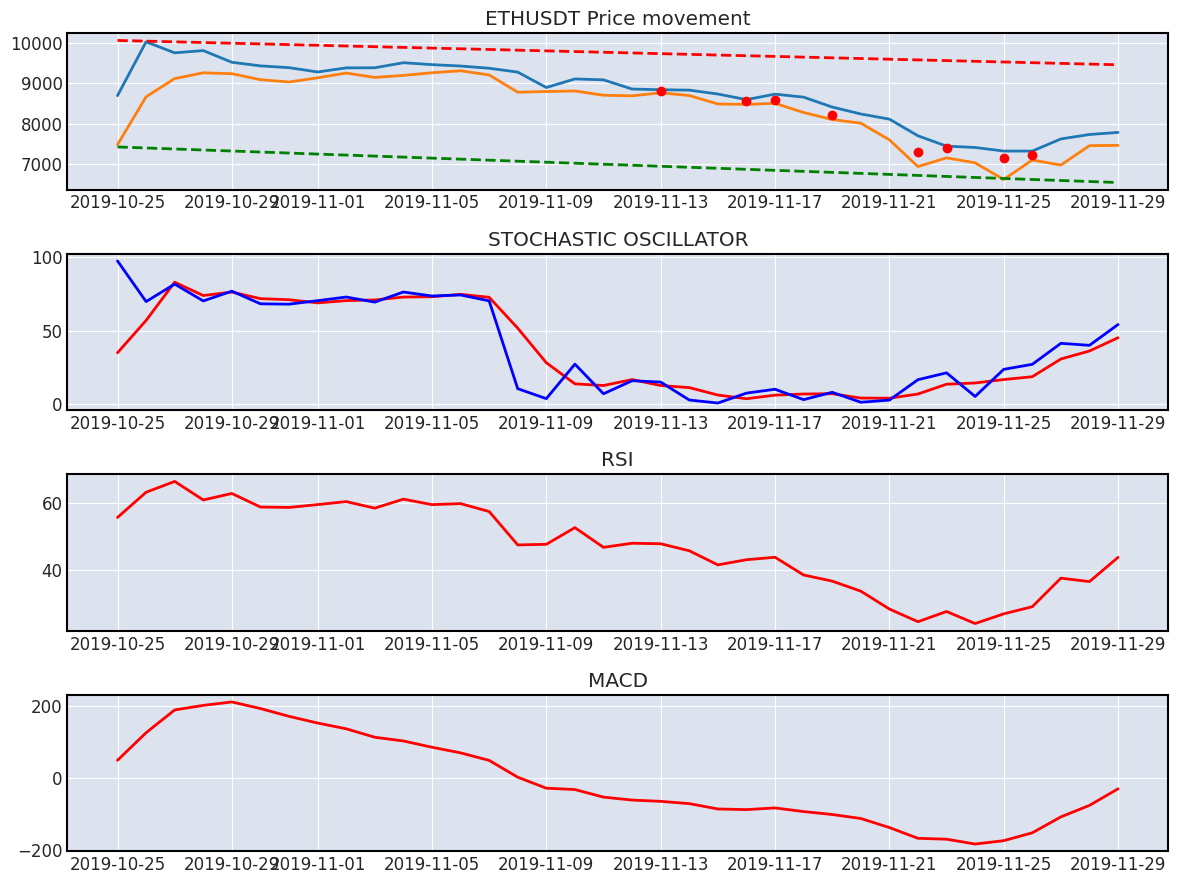

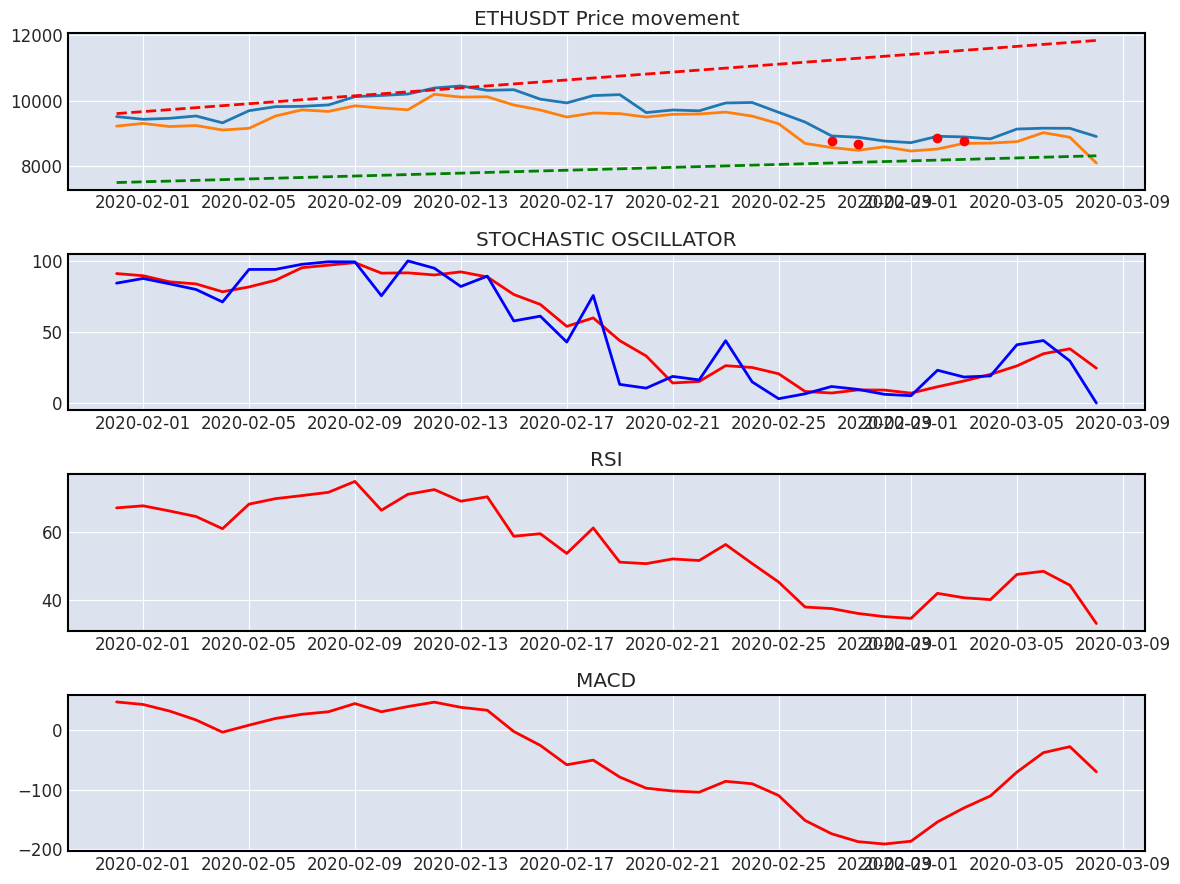

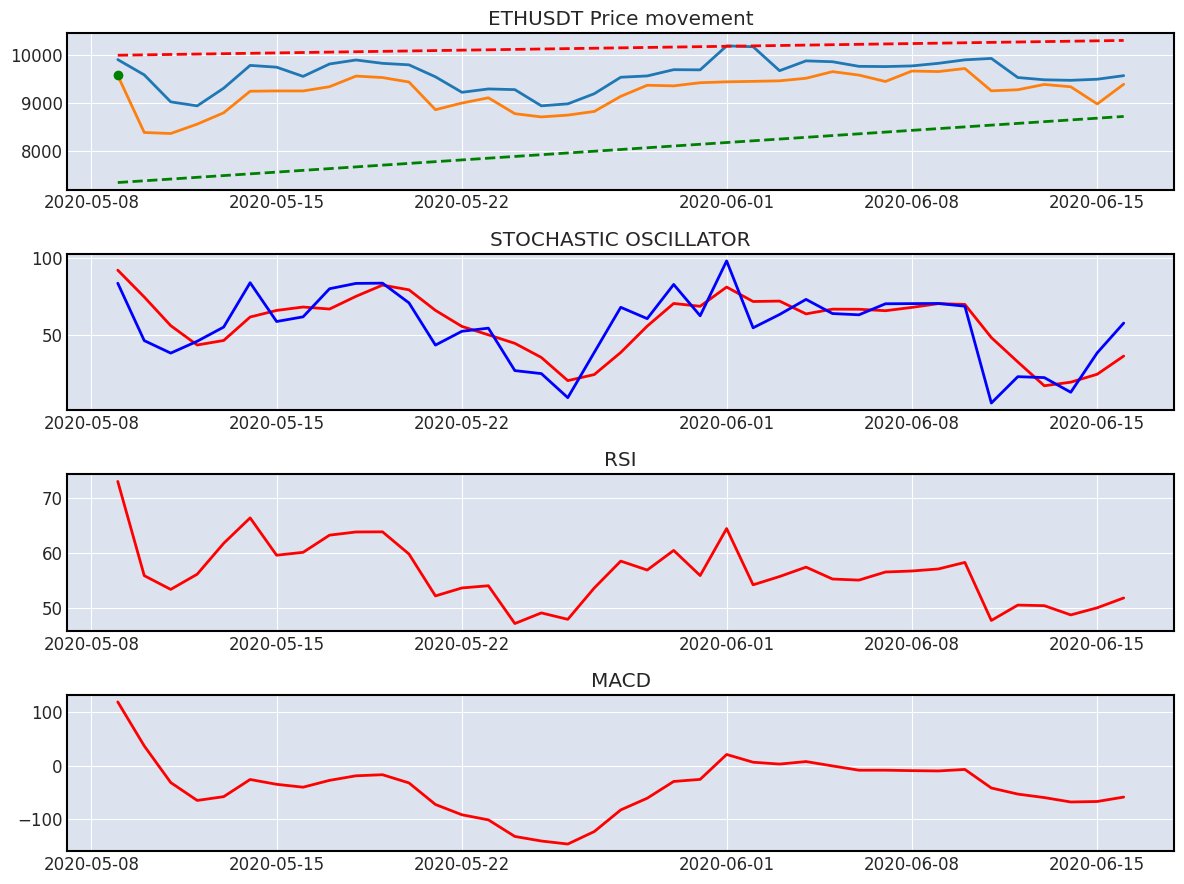

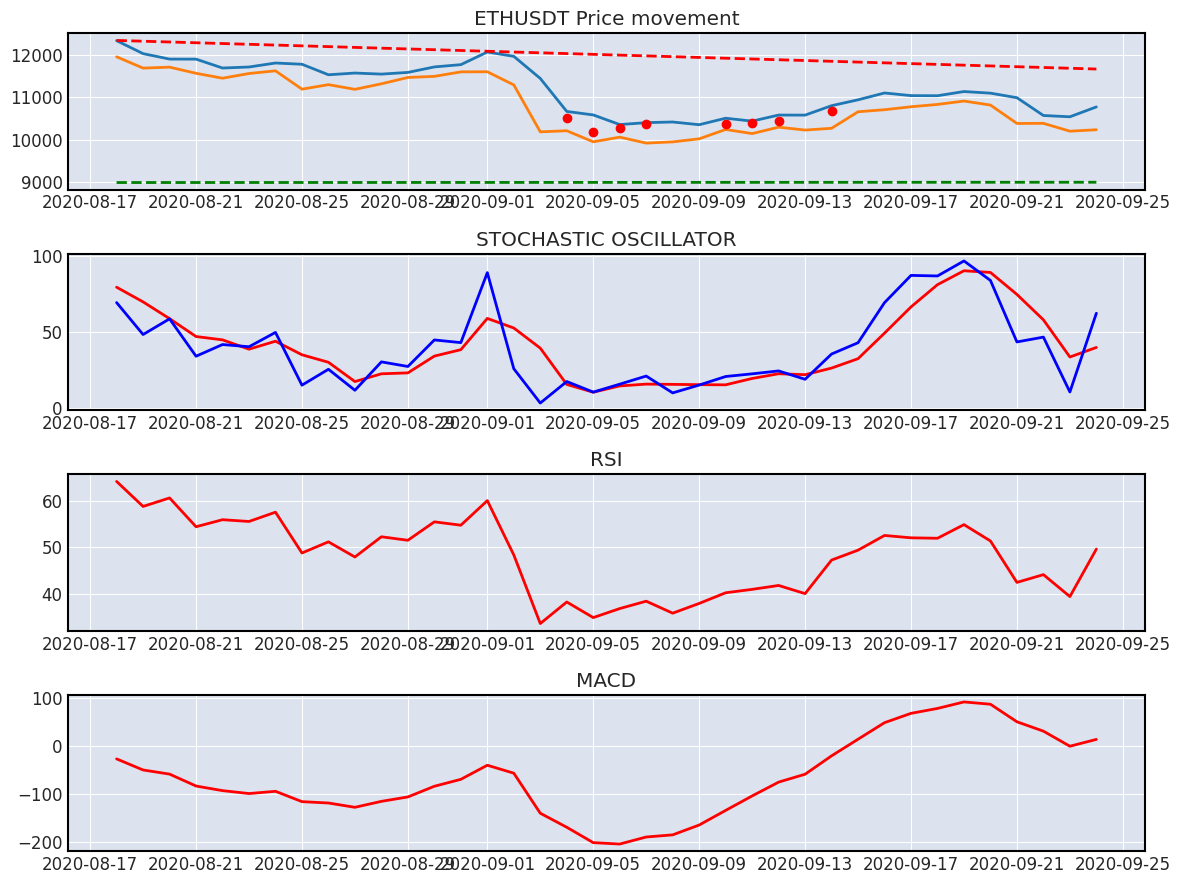

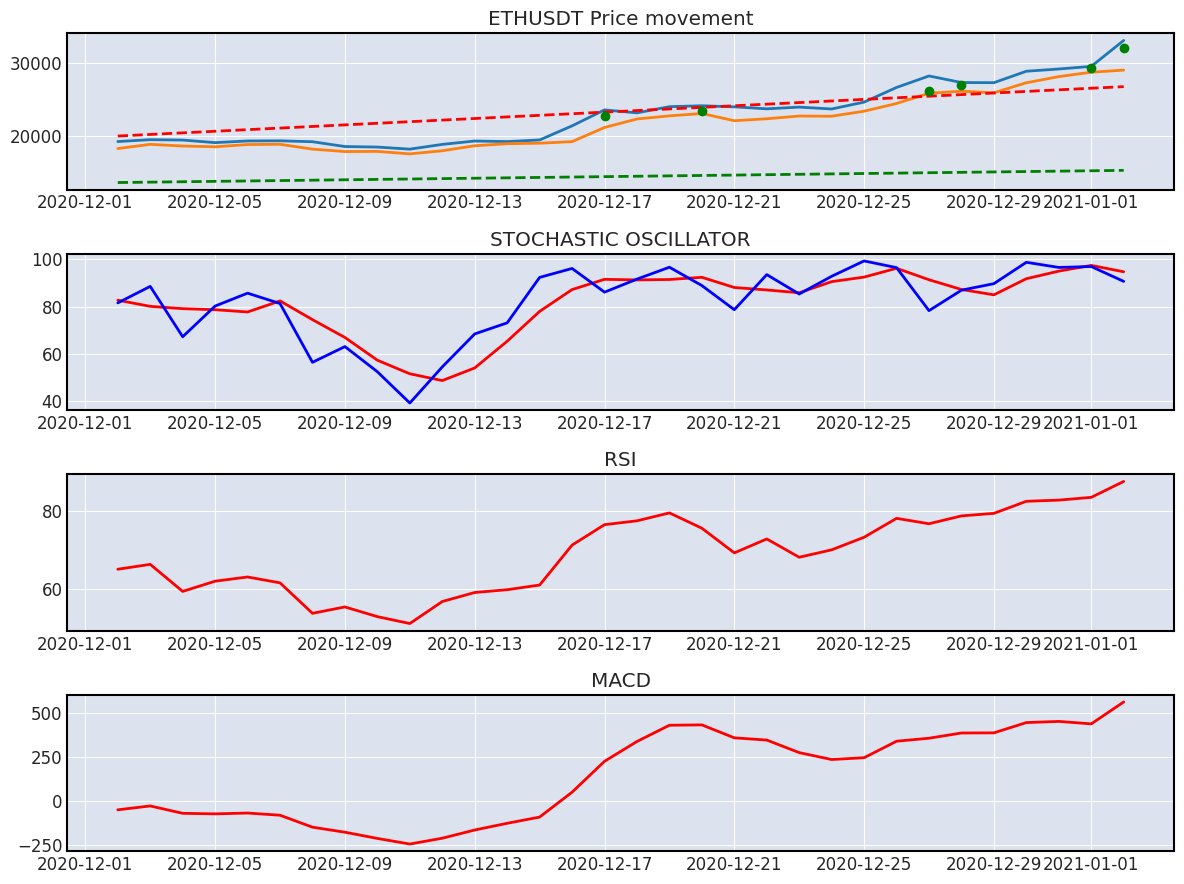

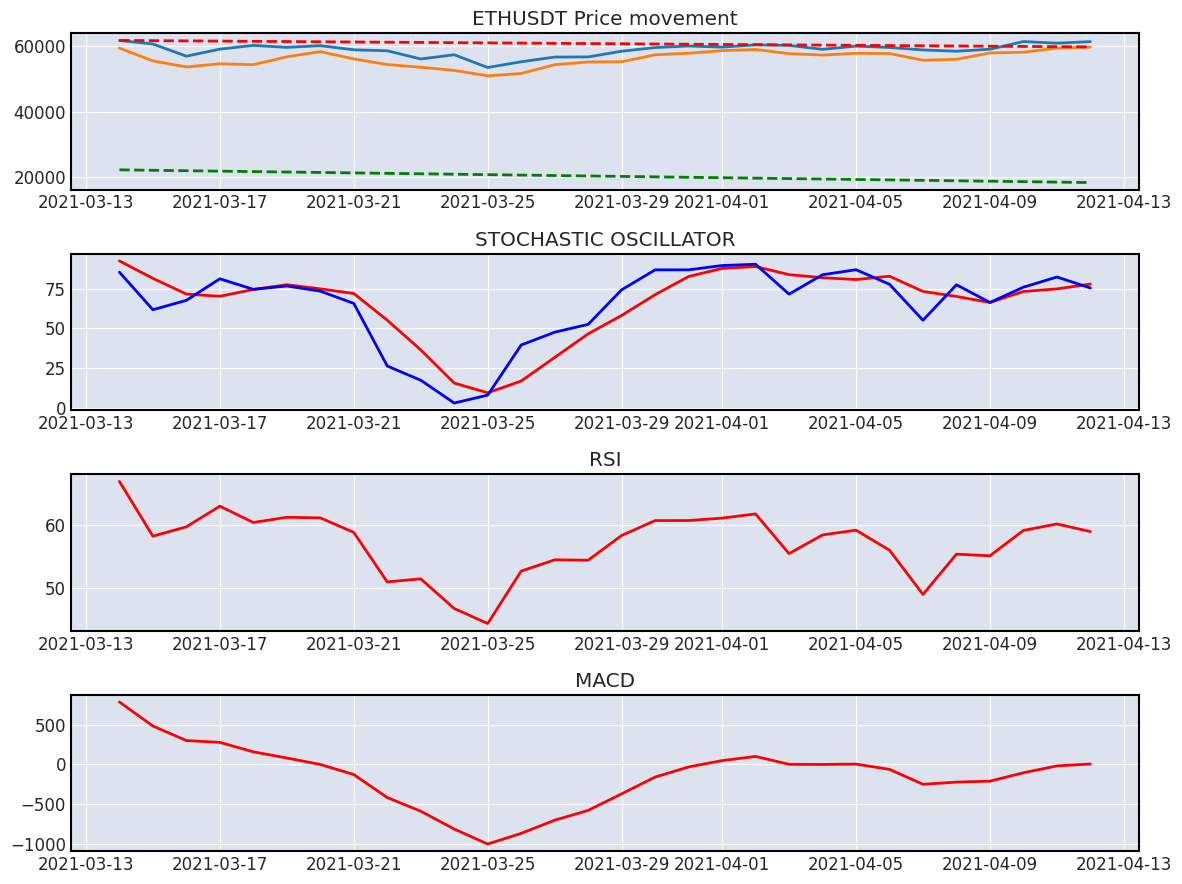

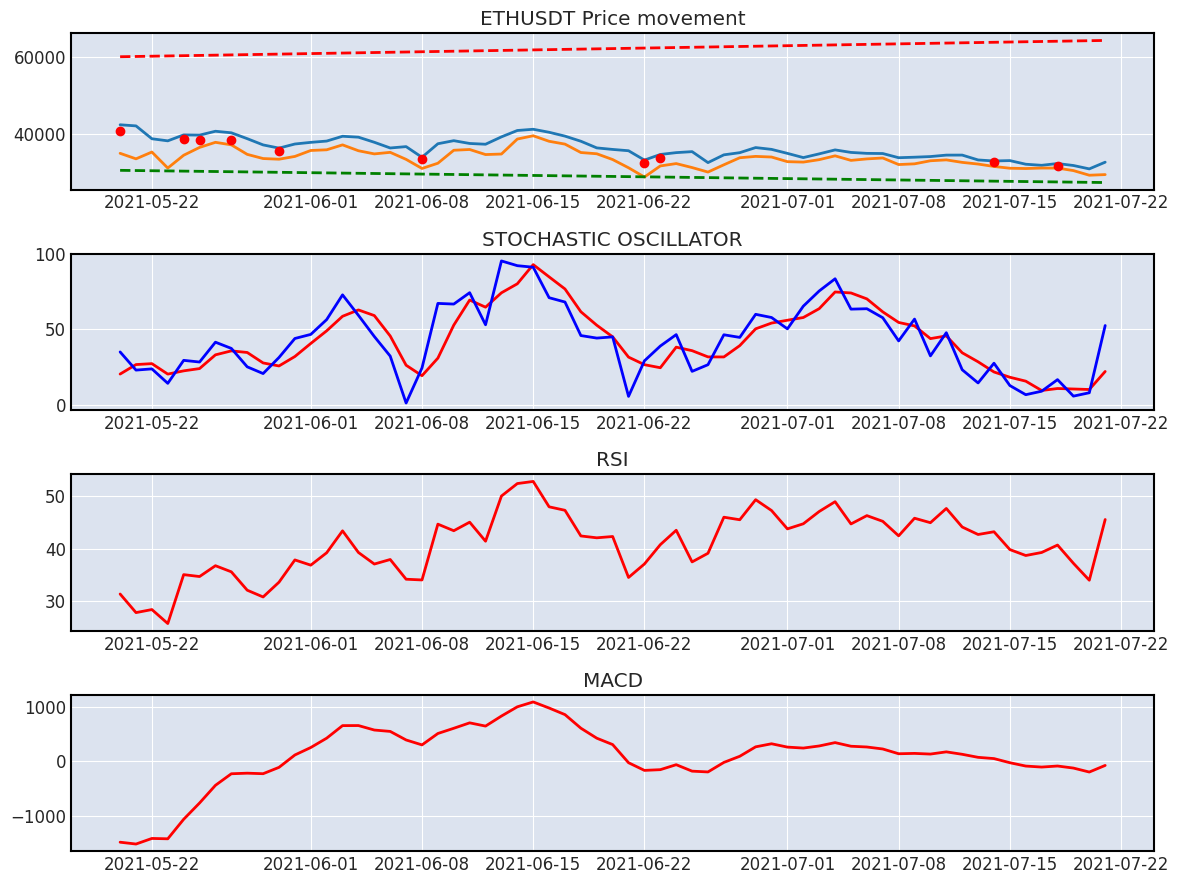

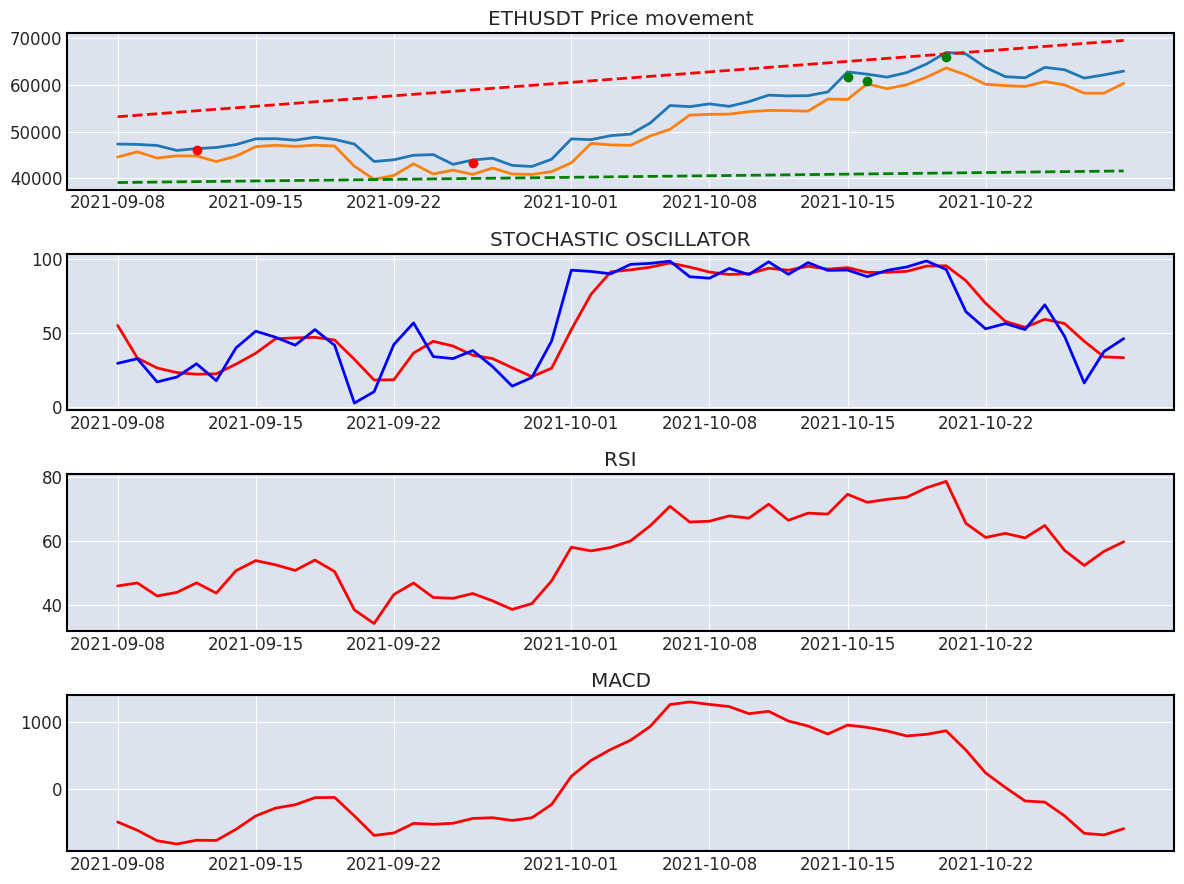

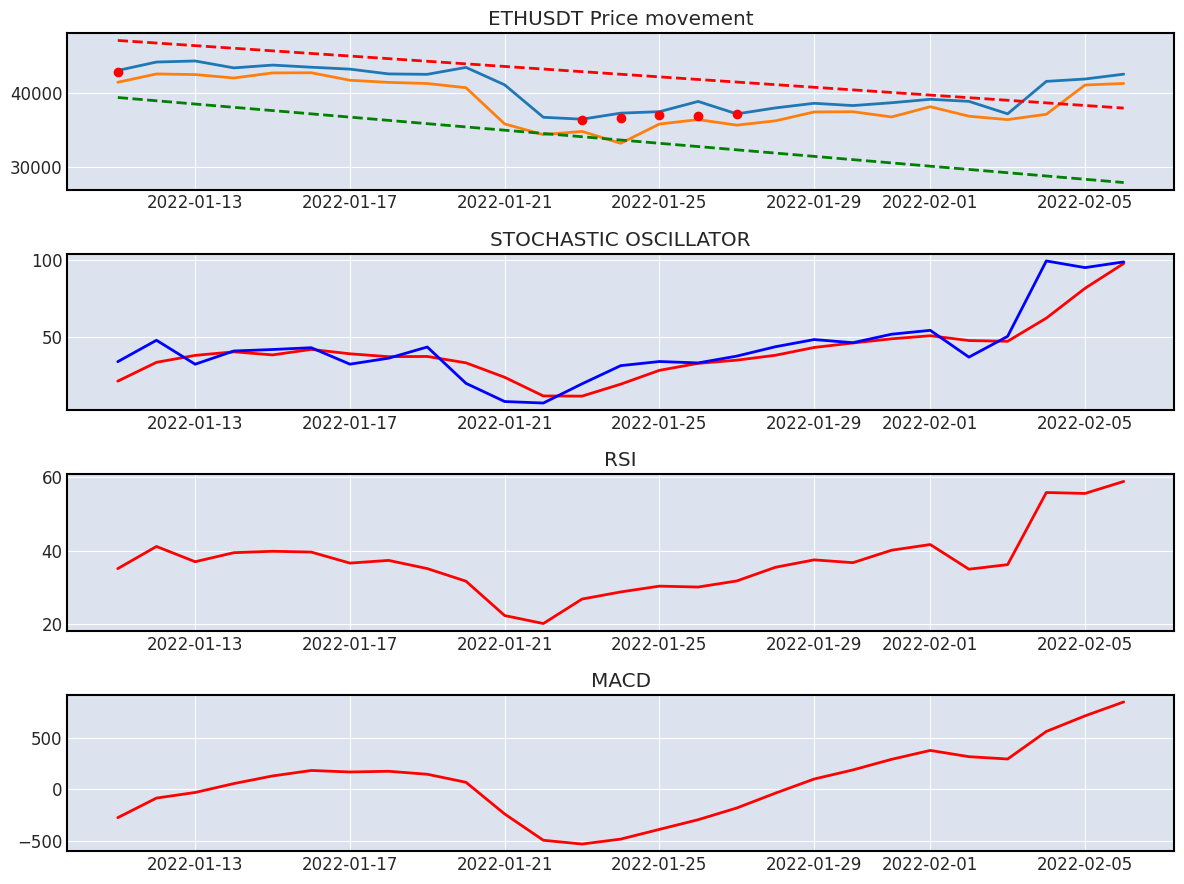

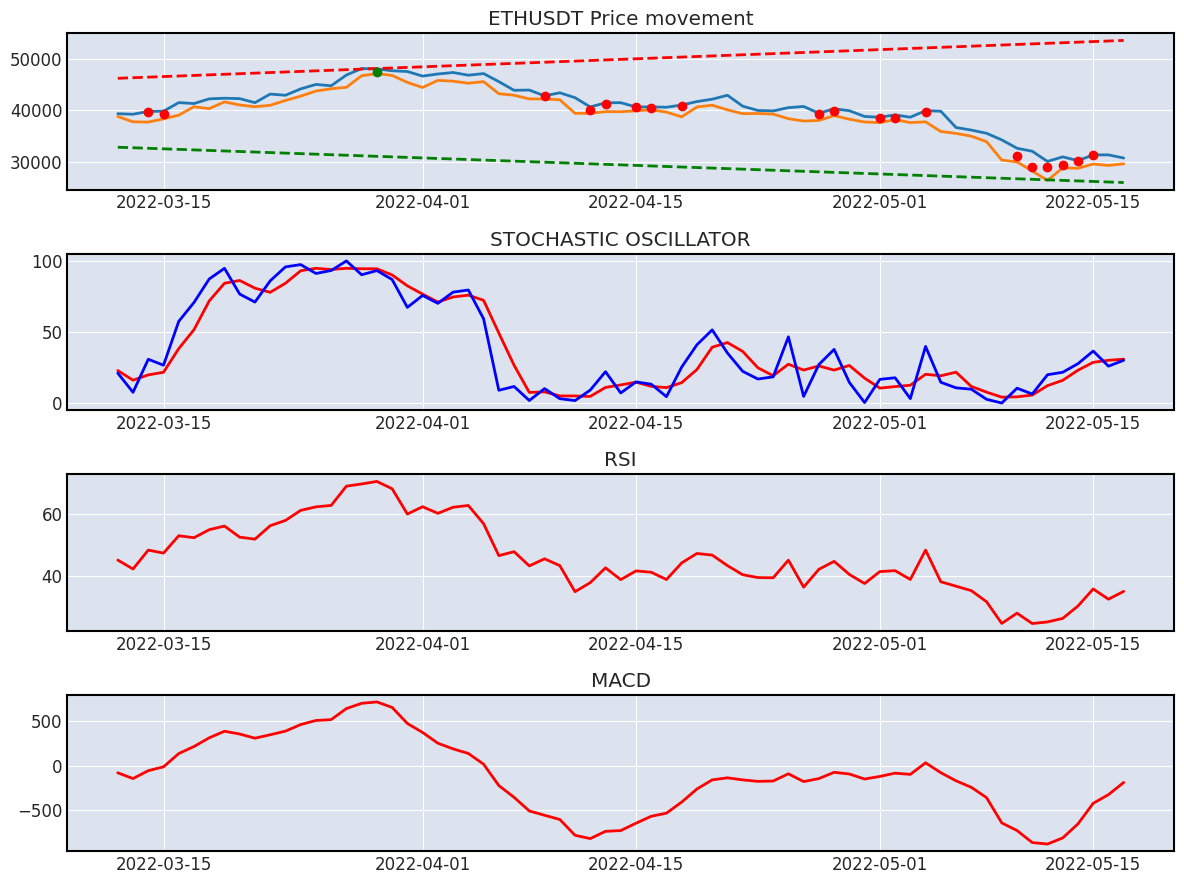

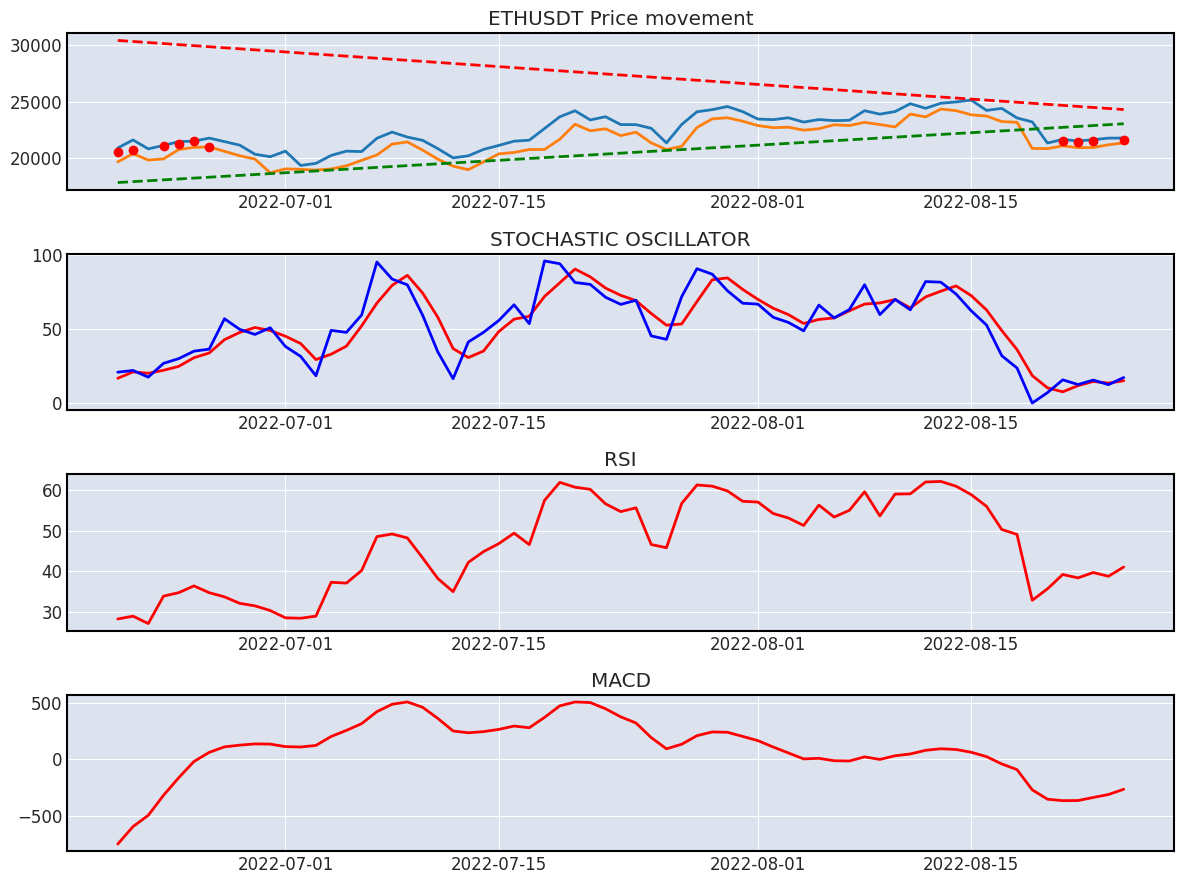

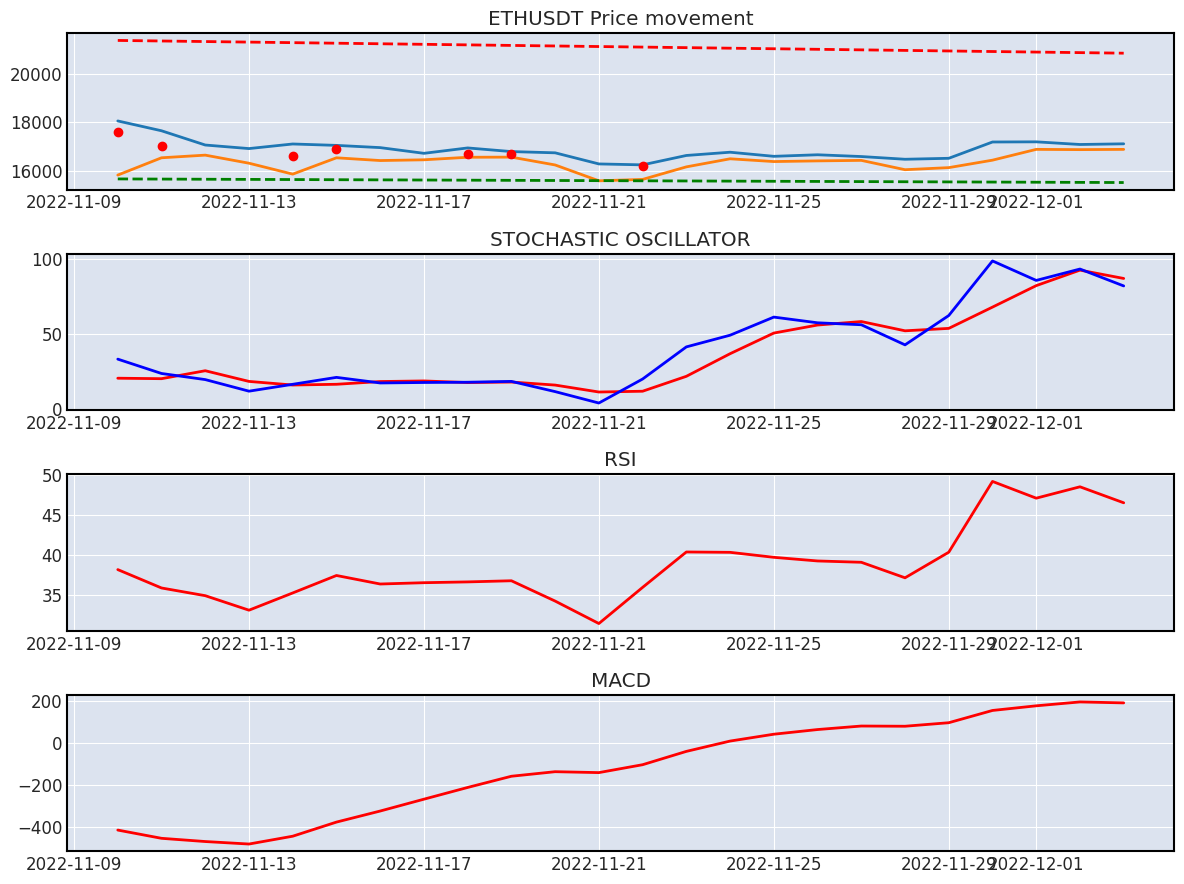

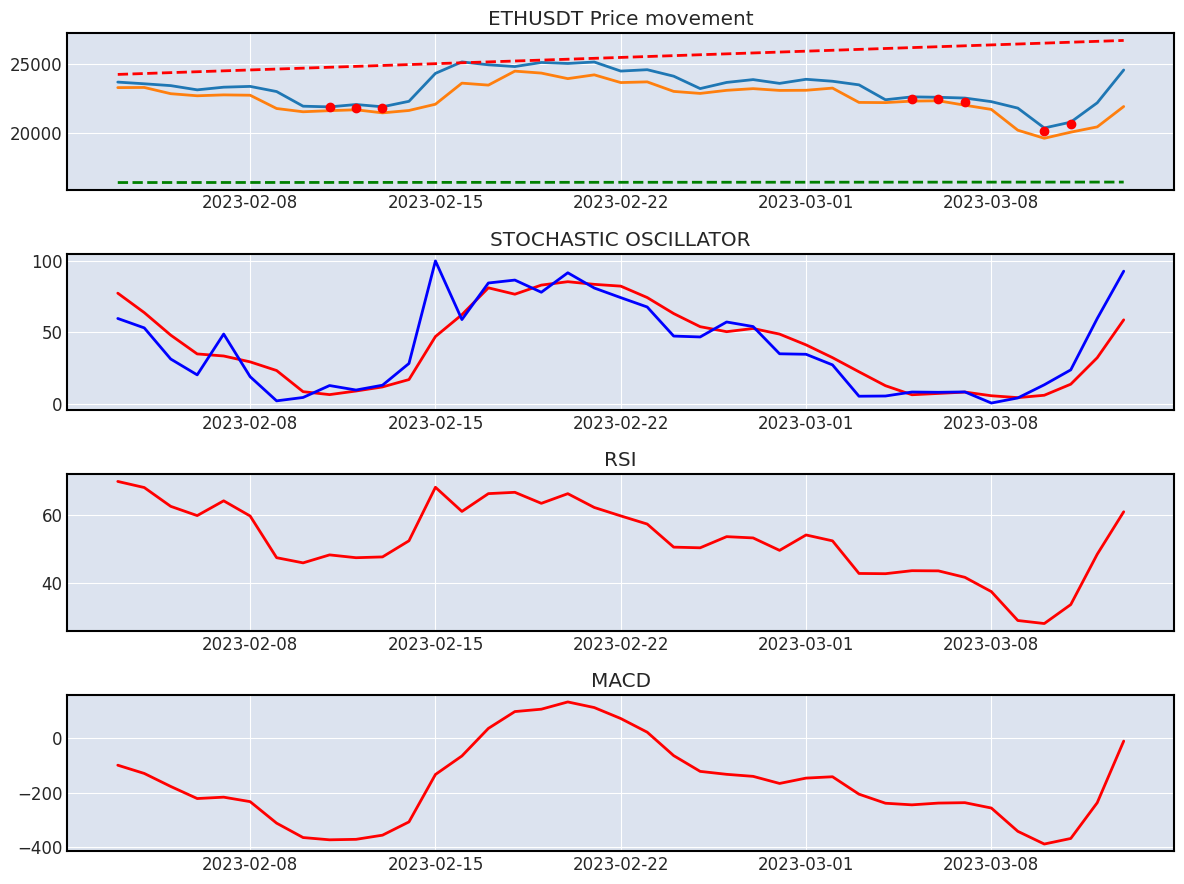

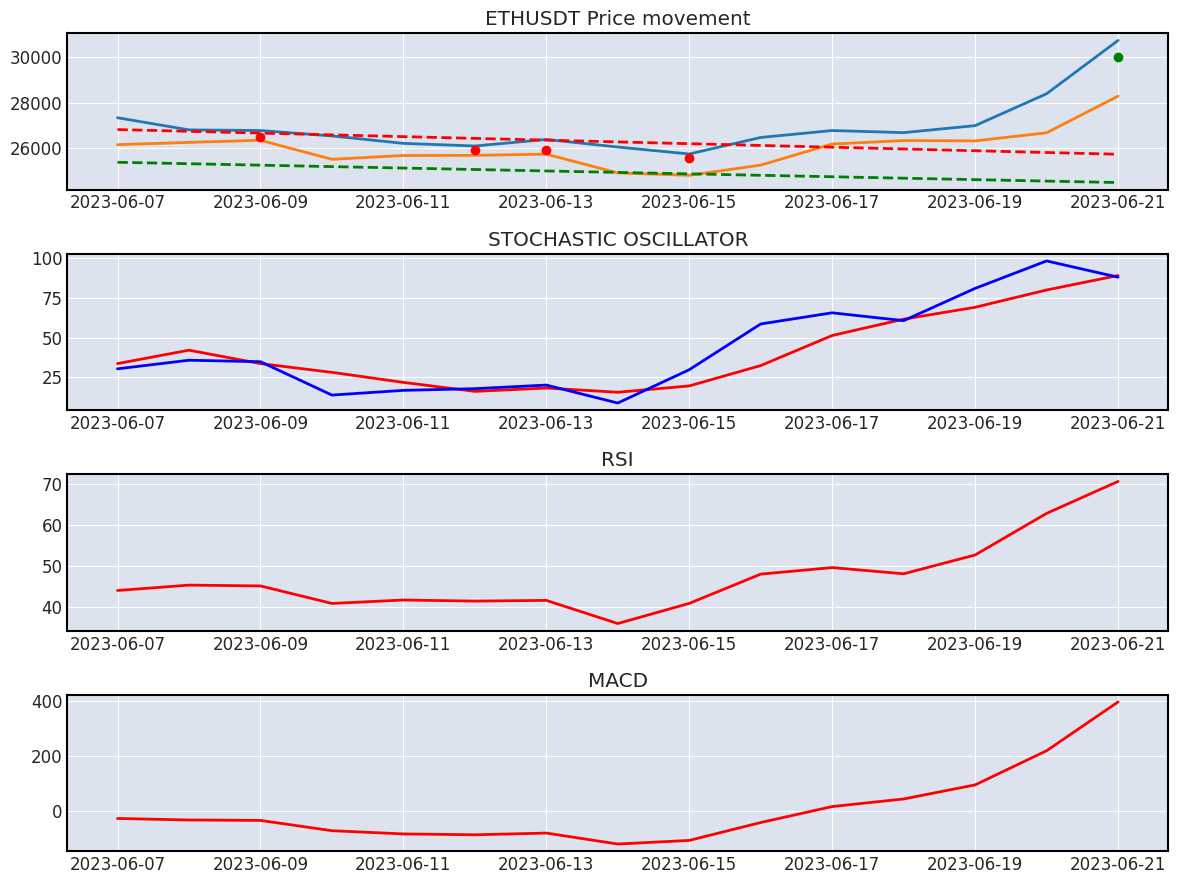

In [1033]:
dataStart = 0
for i in range(100, len(data),100):
    # print('dataStart= ', dataStart, ' i= ', i)
    # ==== setting range of df ====
    df = data[dataStart:i]
    df['resistance'] = np.nan
    df['support'] = np.nan
    data['macd'] = np.nan
    data['rsi'] = np.nan
    data['%D'] = np.nan
    data['%K'] = np.nan
    # ===== Calculate Channel ====
    resistance(df)
    support(df)
    applytechnicals(df)
    decide()
    plot_df(df)
    print("Start= ", dataStart, " end = ", i)
    dataStart = i


УРТ ХУГАЦААГААР ХАРАХ ХЭСЭГ

In [857]:
# with indicator
# df = data
# df['resistance'] = np.nan
# df['support'] = np.nan
# # plt.plot(df.index, df.Close)
# # plt.show()
# # ===== Calculate Channel ====
resistance(df)
support(df)
decide()
# ===== PLOTLY =====
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'],
                                    increasing_line_color='green',
                                    decreasing_line_color='red'),
                                    go.Scatter(x=df.index, y=df['support'], line=dict(color="green", width=3), name="SUPPORT"),
                                    go.Scatter(x=df.index, y=df['resistance'], line=dict(color='red', width=3), name="RESISTANCE"),
                                    go.Scatter(x=df.index, y=df['Buy'], mode="markers", marker=dict(size=5, color="Orange"), name="Buy")])

fig.update(layout_xaxis_rangeslider_visible=True)
fig.update_layout(paper_bgcolor="black", plot_bgcolor="black", margin_l=0, margin_b=0, margin_r=0, margin_t=0)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='white')
fig.show()

ascending
difference =  45.394989013671875
range = 31
max=  457.0929870605469 min=  411.697998046875
ascending
difference =  14.936004638671875
range = 75
max=  304.23199462890625 min=  289.2959899902344


/tmp/ipykernel_3191/738999639.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



POLARS
update row